<h1><Center>Recurrent Neural Network</Center></h1>

# **Imports**

## Libraries

In [76]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Embedding, Dropout, Flatten, Layer, GRU
from tensorflow.keras import utils, initializers, regularizers, constraints
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report,mean_squared_error, mean_absolute_error, r2_score, accuracy_score, roc_curve, auc
from keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
import tensorflow.keras.backend as K

import re
import nltk
import jiwer
import random
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.corpus import wordnet
from nltk.translate.bleu_score import sentence_bleu
from spellchecker import SpellChecker
from textblob import TextBlob
from translate import Translator
from rouge import Rouge

nltk.download('wordnet')
nltk.download('stopwords')

import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ignore warnings
import pickle
import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# **Data Preparation**

## Reading the dataset

- Show the size of rows and columns in the dataset to understand the overall structure.
- Check for missing values and data type to identify missing values and understand the datatypes.
- Checking the number of unique values for each column to understand the diverity and variability in each column.
- Counting rows for each language to see the distribution of reviews across different languages.

### Dataset info

In [77]:
# Load CSV file
data = pd.read_csv('Movie reviews.csv')

# Size of rows and columns
print(f'***Movie Reviews***\n\nThere are {data.shape[0]} rows and {data.shape[1]} columns in this dataset')

# Show the values and datatypes
print(f'\nInformation on datatype and checking for missing values:\n')
print(data.info())

# Check for missing values
print(f"\nCheck if there is missing values:\n{data.isnull().sum()}")

# Number of unique values for each column
print(f"\n*Number of unique values in each column*\n{data['Review'].nunique()} unique values in the 'Review' column")
print(f"{data['Score'].nunique()} unique values in the 'Score' column")
print(f"{data['Language'].nunique()} unique values in the 'Language' column")

# Count rows for each language
language_counts = data.groupby('Language').size()
print(f"\n{language_counts}")

***Movie Reviews***

There are 527 rows and 4 columns in this dataset

Information on datatype and checking for missing values:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 527 entries, 0 to 526
Data columns (total 4 columns):
 #   Column                                                                                 Non-Null Count  Dtype  
---  ------                                                                                 --------------  -----  
 0   Review                                                                                 527 non-null    object 
 1   Score                                                                                  525 non-null    float64
 2   Are there ways for you to generate more data? Spliting up sentences, would that help?  0 non-null      float64
 3   Language                                                                               527 non-null    object 
dtypes: float64(2), object(2)
memory usage: 16.6+ KB
None

Check if the

### Dataset visualisation

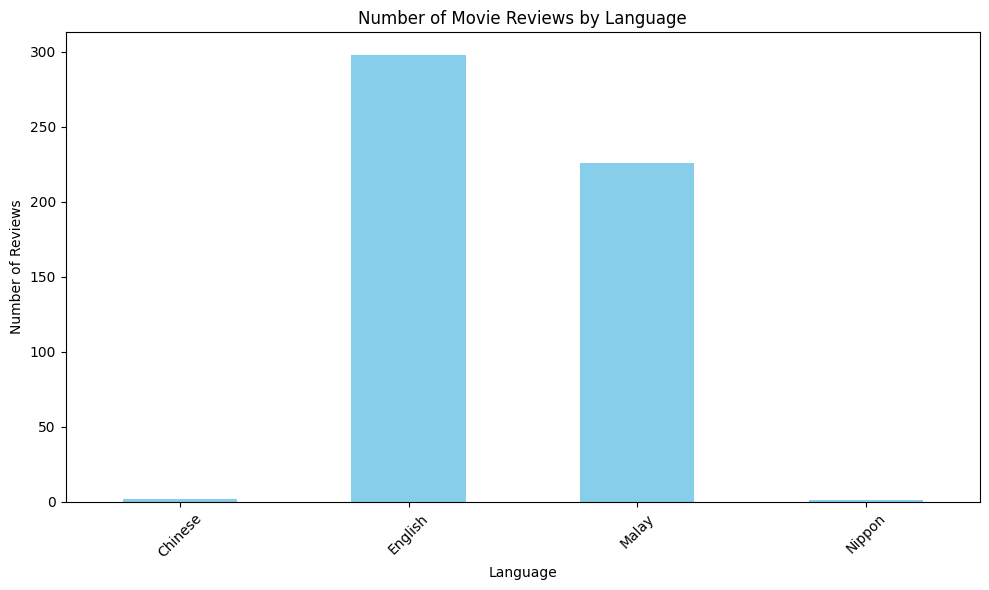

In [78]:
# Set up the figure and axis
plt.figure(figsize=(10, 6))

# Plotting the language counts
language_counts.plot(kind='bar', color='skyblue')

# Adding title and labels
plt.title('Number of Movie Reviews by Language')
plt.xlabel('Language')
plt.ylabel('Number of Reviews')

# Rotating x-axis labels for better readability
plt.xticks(rotation=45)

# Show plot
plt.tight_layout()
plt.show()

## Data Cleaning

- Cleaning the data so that it is accurate, consistent and reliable.
- Cleaning data also reduces computational resources require for analysis and model training by removing unnecessary elements.
  
Processes
- Removing Nippon, Chinese and Malay from the data and focusing on English reviews.
- From file reading analysis, I can see that there are 2 null score values and hence i will remove them using dropna().
- I also saw that there was a redundent column hence i will drop the column.
- Use re (regular expressions) to manipulate the text and pattern matching.
- text.lower to convert all the test to lowercase to ensure consistency in text processing and analysis.
- re.sub to remove non-alphabetic characters from the text.
- word_tokenize to tokenize the text into individual words.
- stop_words to filter out common words such as 'the', 'is', 'and' as they do not carry any meaning on their own.
- [removed] stem to reduce the words into their base or root form, e.g: running/ran/runner to run to capture the essence of the words.
- Finding the mean of duplicated reviews and dropping the rest of the duplicated reviews.
- Spell Checking to identify and correct misspelled words to improve input quality, reduce vocabulary size and increase generalization.

### Dropping unnecessary

In [79]:
# Remove Nippon, Chinese and Malay from the data
data = data[~((data['Language'] == 'Nippon') | (data['Language'] == 'Chinese') | (data['Language'] == 'Malay'))]

# Remove rows with NaN or null values
data.dropna(subset=['Score'], inplace=True)

# Remove redundent column
data.drop(columns=['Are there ways for you to generate more data? Spliting up sentences, would that help?'], inplace=True)

### Text Cleaning

In [80]:
# loading stopwords
stop_words = set(stopwords.words('english'))


# Text cleaning
def clean_text(text):
    
    # Standardize with lowercase
    text = text.lower()  

    # Remove non-alphabetic characters
    text = re.sub(r'[:)(.;,?&!@#$]', '', text)

    # # remove stop words
    # tokens = text.split()
    # filtered_tokens = [word for word in tokens if word.lower() not in stop_words]
    # return ' '.join(filtered_tokens)
    
    return text

# Calling function
data['Review'] = data['Review'].apply(clean_text)

### Duplicate review removal

In [81]:
# Finding the mean scores of duplicates and dropping them

# Finding average score
mean_scores = data.groupby('Review')['Score'].mean().reset_index() 

# Merge mean scores
data = pd.merge(data, mean_scores, on='Review', suffixes=('', '_mean')) 

# Replace the original score
data['Score'] = data['Score_mean'].fillna(data['Score']) 

# Drop duplicates
data = data.drop_duplicates(subset=['Review']) 

# Drop column
data.drop('Score_mean', axis=1, inplace=True) 

### Spell Check

In [82]:
# # Function for Malay spell checking
# def spell_check_malay(text):
#     h = hunspell.HunSpell('MalaySpellChecker/ms_MY.dic', 'MalaySpellChecker/ms_MY.aff')
#     tokens = re.findall(r'\b\w+\b', text)
#     corrected_tokens = [token if h.spell(token) else h.suggest(token)[0] for token in tokens]
#     corrected_text = ' '.join(corrected_tokens)
#     return corrected_text

# # Apply spell checking to Malay reviews
# malay_mask = data['Language'] == 'Malay'
# data.loc[malay_mask, 'Review'] = data.loc[malay_mask, 'Review'].apply(spell_check_malay)

def spell_check_english(text):
    spell = SpellChecker()
    tokens = re.findall(r'\b\w+\b', text)
    corrected_tokens = [spell.correction(token) if spell.correction(token) 
                        is not None else token for token in tokens]
    corrected_text = ' '.join(corrected_tokens)
    return corrected_text

# Apply spell checking to English reviews
english_mask = data['Language'] == 'English'
data.loc[english_mask, 'Review'] = data.loc[english_mask, 'Review'].apply(spell_check_english)


# def spell_check_english(text):
#     # Create a TextBlob object
#     blob = TextBlob(text)
    
#     # Correct the text
#     corrected_text = blob.correct()
    
#     return str(corrected_text)

# # Apply spell checking to English reviews
# english_mask = data['Language'] == 'English'
# data.loc[english_mask, 'Review'] = data.loc[english_mask, 'Review'].apply(spell_check_english)

### Results and Visualisation

*Review after cleaning*
There are 272 rows and 3 columns in this dataset

                                                Review  Score Language
0    this movie is amazing the action is breathtaki...   0.08  English
1    i m disappointed with the actors performance n...   0.70  English
2    the storyline is touching and full of emotion ...   0.12  English
3    this movie delivers an outstanding experience ...   0.05  English
4    too many action scenes sometimes unnecessary t...   0.40  English
..                                                 ...    ...      ...
292          compelling story outstanding performances   0.12  English
293                   intricate plot unexpected twists   0.10  English
294       underwhelming moments weak characterizations   0.60  English
295            breathtaking visuals engaging narrative   0.08  English
296         top notch effects captivating storytelling   0.08  English

[272 rows x 3 columns]


<Figure size 1000x600 with 0 Axes>

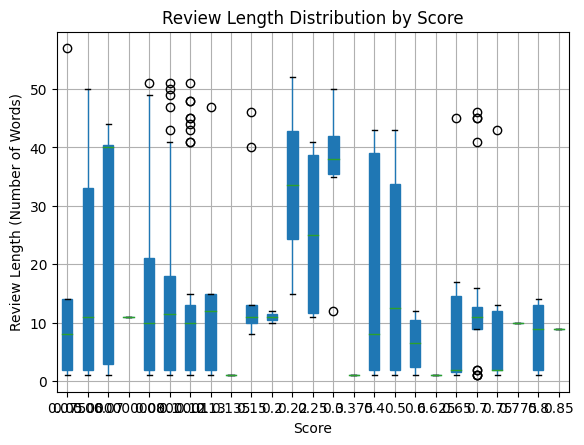

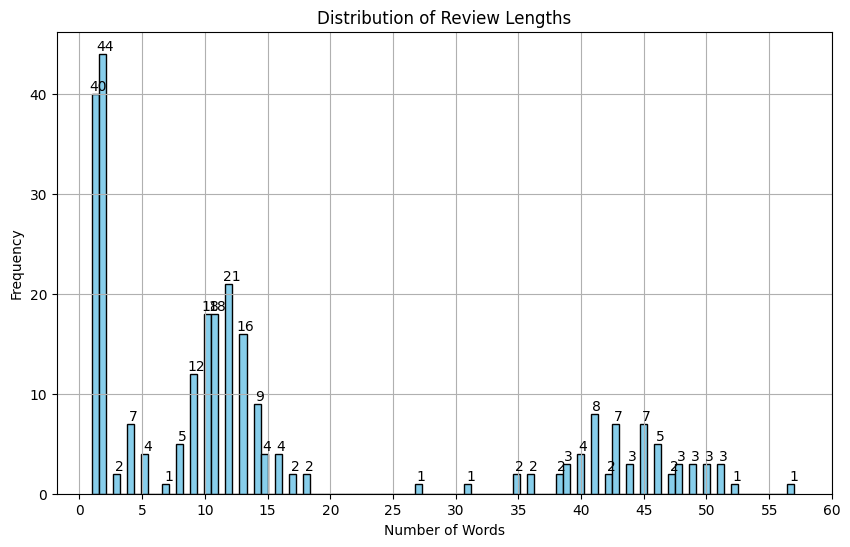

The mean review length (number of words) is: 15.57


In [83]:
# After data cleaning
print(f"*Review after cleaning*\nThere are {data.shape[0]} rows and {data.shape[1]} columns in this dataset\n\n{data}")


# Calculate word count for each review
data['Word_Count'] = data['Review'].str.split().str.len() 

# Create a box plot to visualize review length distribution for each score category
plt.figure(figsize=(10, 6))
boxplot = data.boxplot(column='Word_Count', by='Score', patch_artist=True)
plt.title('Review Length Distribution by Score')
plt.xlabel('Score')
plt.ylabel('Review Length (Number of Words)')
plt.suptitle('')
plt.show()

# Create histogram to visualize the distribution of word counts
plt.figure(figsize=(10, 6))
counts, bins, _ = plt.hist(data['Word_Count'], bins=100, color='skyblue', edgecolor='black')
plt.title('Distribution of Review Lengths')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.grid(True)

# Add numbers to the top of each bar
for count, bin_edge in zip(counts, bins):
    if count != 0:  # Skip bins with zero frequency
        plt.text(bin_edge + 0.5, count, str(int(count)), ha='center', va='bottom')

# Set custom x ticks
plt.xticks(range(0, max(data['Word_Count'])+5,5))

plt.show()


# Find the mean number of words
mean_review_length = data['Word_Count'].mean()
print(f"The mean review length (number of words) is: {mean_review_length:.2f}")

## Data Augmentation

Back translation
- In this method, text data is translated to some language and then translated back to the original language. This can help to generate textual data with different words while preserving the context of the text data.

Easy Data Augmentation
- It uses traditional and very simple data augmentation methods. EDA consists of 4 simple operations that helps with preventing overfitting and train more robust models.
- Synonym Replacement: It randomly choose n words from the sentence that are not stop words and replace them with one of its synonyms at random.
- Random Insertion: Finds a random synonym of a random word that is not a stop word and insert it into a random position in the sentence.
- Random Swap: Randomly choose 2 words in the sentence and swap their positions.
- Random Deletion: Randomly remove each word in the sentence with probability p.

NLP Albumentation
- Shuffle Sentences Transform: If the given text sample contains multiple sentences, these sentences are shuffled to create a new sample.
- Exclude duplicate transform. If the given text sample contains multiple sentences with duplicated sentences, these will be removed to create a new sample.

Reference: https://neptune.ai/blog/data-augmentation-nlp

### Easy Data Augmentation

In [84]:
# Set stopwords to english
stop_words = set(stopwords.words('english'))

# Function to get synonyms of a word
def get_synonyms(word):
    synonyms = set()
    for syn in wordnet.synsets(word):
        for lemma in syn.lemmas():
            synonym = lemma.name().replace("_", " ").replace("-", " ").lower()
            synonym = "".join([char for char in synonym if char in ' qwertyuiopasdfghjklzxcvbnm'])
            synonyms.add(synonym) 
    return synonyms

# Function to perform synonym replacement
def synonym_replacement(sentence, n):
    words = sentence.split()
    new_words = words.copy()
    # Filter out stopwords from the words list
    random_word_list = list(set([word for word in words if word not in stop_words]))
    random.shuffle(random_word_list)
    num_replaced = 0
    # Iterate over the shuffled list and replace words with synonyms
    for random_word in random_word_list:
        synonyms = get_synonyms(random_word)
        if len(synonyms) >= 1:
            synonym = random.choice(list(synonyms))
            new_words = [synonym if word == random_word else word for word in new_words]
            num_replaced += 1
        if num_replaced >= n:
            break
    sentence = ' '.join(new_words)
    return sentence

# Function to perform random insertion
def random_insertion(sentence, n):
    words = sentence.split()
    for _ in range(n):
        new_synonym = get_synonyms(random.choice(words))
        if new_synonym:
            words.insert(random.randint(0, len(words)), list(new_synonym)[0])
    return ' '.join(words)

def random_swap(sentence, n):
    words = sentence.split()
    if len(words) < 2:
        return sentence
    for _ in range(n):
        # Randomly select two indices from sentence
        random_index_1 = random.randint(0, len(words)-1)
        random_index_2 = random_index_1
        # Ensure the two indices are different
        while random_index_2 == random_index_1:
            random_index_2 = random.randint(0, len(words)-1)
            # Swap words at the selected indices        
        words[random_index_1], words[random_index_2] = words[random_index_2], words[random_index_1] 
    return ' '.join(words)


def random_deletion(sentence, p):
    words = sentence.split()
    if len(words) == 1:
        return sentence
    # Filter words randomly based on probability p    
    remaining = list(filter(lambda x: random.uniform(0,1) > p, words))
    if len(remaining) == 0:
        return random.choice(words)
    else:
        return ' '.join(remaining)

### Back translation

In [85]:
# Function to perform back translation using Google Translate
def back_translation(sentence, intermediate_lang='es'):
        # Translate the sentence to the intermediate language
        translator = Translator(to_lang=intermediate_lang)
        translated = translator.translate(sentence)
        
        # Translate the intermediate language back to English
        translator = Translator(from_lang=intermediate_lang, to_lang='en')
        back_translated = translator.translate(translated)
        
        return back_translated

### NLP Albumentation

In [86]:
# Function to shuffle sentences
def shuffle_sentences(text):
    # Split the text into sentences
    sentences = text.split('.')
    # Remove empty strings (resulting from consecutive periods)
    sentences = [sentence.strip() for sentence in sentences if sentence.strip()]
    # Shuffle the order of sentences
    random.shuffle(sentences)
    # Join the shuffled sentences back into a single text
    shuffled_text = '. '.join(sentences)
    return shuffled_text

# Function to shuffle exclude duplicate sentences
def shuffle_sentences_exclude_duplicates(text):
    # Split the text into sentences
    sentences = text.split('.')
    # Remove empty strings (resulting from consecutive periods)
    sentences = [sentence.strip() for sentence in sentences if sentence.strip()]
    # Remove duplicate sentences
    unique_sentences = list(set(sentences))
    # Shuffle the order of unique sentences
    random.shuffle(unique_sentences)
    # Join the shuffled unique sentences back into a single text
    shuffled_text = '. '.join(unique_sentences)
    return shuffled_text

### Calling data augmentaion functions

In [87]:
# List for augmented data
augmented_review = []

# Number of augmentations
num_augment = 3

# Apply data augmentation
for i, (review, score) in enumerate(zip(data['Review'], data['Score'])):
    
    # Append original review
    augmented_review.append((review, score))
    
    # Easy Data Augmentation
    for _ in range(num_augment):
        augmented_review.append((synonym_replacement(review, n=5), score))
        # augmented_review.append((random_insertion(review, n=1), score))
        # augmented_review.append((random_swap(review, n=1), score))
        # augmented_review.append((random_deletion(review, p=0.1), score))

    # # NLP Albumentation
    # augmented_review.append((shuffle_sentences(review), score))
    # augmented_review.append((shuffle_sentences_exclude_duplicates(review), score))
    
    # Back translation
    augmented_review.append((back_translation(review, intermediate_lang='es'), score))

# Back translation warning removal
augmented_review = [item for item in augmented_review if "MYMEMORY WARNING: YOU USED ALL AVAILABLE FREE TRANSLATIONS FOR TODAY" not in item[0]]

# Now 'augmented_review' contains the original and augmented reviews
print(f'Total reviews after augmentation: {len(augmented_review)}')

# Display original and augmented reviews
for review, score in augmented_review:
    print(review, score)

Total reviews after augmentation: 1088
this movie is amazing the action is breathtaking and the plot is intriguing 0.08
this flick is awe inspiring the carry out is breathtaking and the diagram is intriguing 0.08
this picture is vex the accomplish is breathtaking and the plot is intriguing 0.08
this motion picture show is stupefy the activeness is breathtaking and the secret plan is intrigue 0.08
i m disappointed with the actors performance not satisfying 0.7
i m thwarted with the actor operation not gratify 0.7
i m let down with the worker public presentation not fulfill 0.7
i m defeated with the actor performance not satisfying 0.7
the storyline is touching and full of emotion i love it 0.12
the storyline is refer and replete of emotion i roll in the hay it 0.12
the storyline is disturb and replete of emotion i beloved it 0.12
the storyline is tinct and full of the moon of emotion i enjoy it 0.12
this movie delivers an outstanding experience truly captivating 0.05
this flick delivers

## Text Preprocessing

- Tokenisation: The text is divided into smaller units called tokens. It enables computers to understand and process human language by breaking down text into manageable units that can be analyzed, manipulated, and used as input for the RNN models. Converts text to a sequence of integers.
- Input-output pairs: Used for preparing data for training sequence prediction models, where each input sequence is paired with its corresponding output sequence. Input-output pairs increasing in lengths as input and the next integer in the sequence as output.
- Padding: Used to ensure that all sequences in the dataset have the same length, which simplifies the processing of sequential data and facilitates the training of RNN models. Zeros are added to sequence that are shorter than the maximum sequence length. There are two types 'Pre-padding' where the padding tokens are added to the beginning of the sequences and 'Post-padding' where the padding tokens are added to the end of the sequences. 

### Instantiate Tokenizer to find total unique words

In [88]:
# Instantiate a Tokenizer object.
tokenizer = Tokenizer()

# Extract reviews from the original dataset
original_reviews = data['Review'].tolist()

# Fit the Tokenizer on the dataset. This will map words in the dataset to integers.
tokenizer.fit_on_texts(original_reviews)

# Word-to-index mapping
word_index_original = tokenizer.word_index

# + 1 because index 0 is reserved for padding.
total_words_original = len(tokenizer.word_index) + 1
print(f'total words original: {total_words_original}')


# Extract review texts from augmented_review
augmented_reviews_text = [review for review, _ in augmented_review]

# Fit the Tokenizer on the augmented review texts
tokenizer.fit_on_texts(augmented_reviews_text) 

# Word-to-index mapping
word_index_augmented = tokenizer.word_index

# + 1 because index 0 is reserved for padding.
total_words_augmented = len(tokenizer.word_index) + 1
print(f'total words augmented: {total_words_augmented}')

total words original: 730
total words augmented: 1781


### Visualising the Tokenizer's conversion

In [89]:
# Under the Tokenizer object, convert texts to sequences of integers.

# Print and tokenize original review
original_review = data['Review'][0]  # Assuming original_data is your original dataset
print("Original Review:")
print(original_review)

# Tokenize the original review
original_review_sequence = tokenizer.texts_to_sequences([original_review])[0]
print("\nTokenized Original Review:")
print(original_review_sequence)


# Print and tokenize augmented review
augmented_review_sample = augmented_review[1]
print("Augmented Review:")
print(augmented_review_sample[0])  # First element of the tuple is the review text

# Tokenize the augmented review
augmented_review_sequence = tokenizer.texts_to_sequences([augmented_review_sample[0]])[0]
print("\nTokenized Augmented Review:")
print(augmented_review_sequence)

# Convert the sequence back into words
augmented_review_words = [tokenizer.index_word[index] for index in augmented_review_sequence]
# Join the words to form the augmented review sentence
augmented_review_sentence = ' '.join(augmented_review_words)
print("\nAugmented Review (Reconstructed from Tokens):")
print(augmented_review_sentence)


Original Review:
this movie is amazing the action is breathtaking and the plot is intriguing

Tokenized Original Review:
[13, 141, 7, 166, 1, 12, 7, 66, 4, 1, 11, 7, 137]
Augmented Review:
this flick is awe inspiring the carry out is breathtaking and the diagram is intriguing

Tokenized Augmented Review:
[13, 467, 7, 197, 179, 1, 311, 157, 7, 66, 4, 1, 401, 7, 137]

Augmented Review (Reconstructed from Tokens):
this flick is awe inspiring the carry out is breathtaking and the diagram is intriguing


### Tokenization of reviews

In [90]:
# Tokenization for original data reviews
input_sequences_original = []
for _, row in data.iterrows():
    review_text = row['Review']  # Extracting the review text from the row
    score = row['Score']  # Extracting the score from the row
    token_list = tokenizer.texts_to_sequences([review_text])[0]  # Converting text to integer sequence
    input_sequences_original.append((token_list, score))

print(f'Total number of original reviews: {len(input_sequences_original)}')


# Tokenization for augmentated data reviews
input_sequences_augmented = []
for datapoint in augmented_review:
    review_text = datapoint[0]  # Extracting the review text from the tuple
    score = datapoint[1]  # Extracting the score from the tuple
    token_list = tokenizer.texts_to_sequences([review_text])[0]  # Converting text to integer sequence
    input_sequences_augmented.append((token_list, score))

print(f'Total number of augmented reviews: {len(input_sequences_augmented)}')

Total number of original reviews: 272
Total number of augmented reviews: 1088


### Sequence Generation (augmenting more data)

In [91]:
# Create input-output pairs for original dataset
input_sequences_original = []
for _, row in data.iterrows():
    review_text = row['Review']  # Extracting the review text
    score = row['Score']  # Extracting the score
    seq = tokenizer.texts_to_sequences([review_text])[0]  # Tokenizing the review text
    for i in range(1, len(seq)):
        input_sequences_original.append((seq[:i+1], score))
print(f'Total number of input-output pairs for original dataset with scores: {len(input_sequences_original)}')


# Create input-output pairs for augmented_review
input_sequences_augmented = []
for datapoint in augmented_review:
    review_text = datapoint[0]
    score = datapoint[1]
    seq = tokenizer.texts_to_sequences([review_text])[0]
    for i in range(1, len(seq)):
        input_sequences_augmented.append((seq[:i+1], score))
print(f'Total number of input-output pairs for augmented_review with scores: {len(input_sequences_augmented)}')

Total number of input-output pairs for original dataset with scores: 3963
Total number of input-output pairs for augmented_review with scores: 16459


### Padding Sequences

In [92]:
# Calculate the longest sequence of texts for original dataset
max_sequence_len_original = max([len(x[0]) for x in input_sequences_original]) 

# Calculate the longest sequence of texts for augmented dataset
max_sequence_len_augmented = max([len(x[0]) for x in input_sequences_augmented]) 

# Define a function to add pre-padding to sequences while keeping scores
def add_pre_padding(input_sequences_with_scores, max_sequence_len):
    padded_sequences = []
    for seq_with_score in input_sequences_with_scores:
        seq = seq_with_score[0]
        score = seq_with_score[1]
        padded_seq = pad_sequences([seq], maxlen=max_sequence_len, padding='pre')[0]
        padded_sequences.append((padded_seq, score))
    return padded_sequences

# Add pre-padding to input sequences while keeping scores
padded_input_sequences_original = add_pre_padding(input_sequences_original, max_sequence_len_original)

# Add pre-padding to input sequences while keeping scores
padded_input_sequences_augmented = add_pre_padding(input_sequences_augmented, max_sequence_len_augmented)

# Print the padded input-output pairs with scores
for pair_with_score in padded_input_sequences_original:
    print(pair_with_score)

# Print the padded input-output pairs with scores
for pair_with_score in padded_input_sequences_augmented:
    print(pair_with_score)

(array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,  13, 141]), 0.08)
(array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,  13, 141,   7]), 0.08)
(array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,  13, 141,   7, 166]), 0.08)
(array([  0, 

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



## Split data for Model Training

In [93]:
from sklearn.model_selection import train_test_split

# Convert the padded input-output pairs into separate lists of sequences and scores for Original dataset
sequences = [pair[0] for pair in padded_input_sequences_original]
scores = [pair[1] for pair in padded_input_sequences_original]

# Split the data into training and testing sets
X_train_original, X_test_original, y_train_original, y_test_original = train_test_split(sequences, scores, test_size=0.2, random_state=42)

# Convert into np.array
X_train_original = np.array(X_train_original)
X_test_original = np.array(X_test_original)
# Convert each sentiment score to binary labels
y_train_original = np.array(y_train_original)
y_test_original = np.array(y_test_original)
# y_train_original = np.array([1 if score < 0.5 else 0 for score in y_train_original])
# y_test_original = np.array([1 if score < 0.5 else 0 for score in y_test_original])
# y_train_original = y_train_original.reshape(-1, 1)
# y_test_original = y_test_original.reshape(-1, 1)

# Print the lengths of training and testing sets
print("Length of X_train_original:", len(X_train_original), type(X_train_original))
print("Length of y_train_original:", len(y_train_original), type(y_train_original))
print("Length of X_test_original:", len(X_test_original), type(X_test_original))
print("Length of y_test_original:", len(y_test_original), type(y_test_original))



# Convert the padded input-output pairs into separate lists of sequences and scores for Augmented dataset
sequences = [pair[0] for pair in padded_input_sequences_augmented]
scores = [pair[1] for pair in padded_input_sequences_augmented]

# Split the data into training and testing sets
X_train_augmented, X_test_augmented, y_train_augmented, y_test_augmented = train_test_split(sequences, scores, test_size=0.2, random_state=42)

# Convert into np.array
X_train_augmented = np.array(X_train_augmented)
X_test_augmented = np.array(X_test_augmented)
# # Convert each sentiment score to binary labels
y_train_augmented = np.array(y_train_augmented)
y_test_augmented = np.array(y_test_augmented)
# y_train_augmented = np.array([1 if score < 0.5 else 0 for score in y_train_augmented])
# y_test_augmented = np.array([1 if score < 0.5 else 0 for score in y_test_augmented])

# Print the lengths of training and testing sets
print("Length of X_train_augmented:", len(X_train_augmented), type(X_train_augmented))
print("Length of y_train_augmented:", len(y_train_augmented), type(y_train_augmented))
print("Length of X_test_augmented:", len(X_test_augmented), type(X_test_augmented))
print("Length of y_test_augmented:", len(y_test_augmented), type(y_test_augmented))

Length of X_train_original: 3170 <class 'numpy.ndarray'>
Length of y_train_original: 3170 <class 'numpy.ndarray'>
Length of X_test_original: 793 <class 'numpy.ndarray'>
Length of y_test_original: 793 <class 'numpy.ndarray'>
Length of X_train_augmented: 13167 <class 'numpy.ndarray'>
Length of y_train_augmented: 13167 <class 'numpy.ndarray'>
Length of X_test_augmented: 3292 <class 'numpy.ndarray'>
Length of y_test_augmented: 3292 <class 'numpy.ndarray'>


# **Modelling**

## Evaluation Functions

Evalaute Classification Results
- Calculate and evaluates the trained model's performance on the test dataset. It calculates the accuracy of the model on the test data.
- Generates and displays a confusion matrix to visualize the performance of the classification model which shows the counts of true positive, true negative, false positive, and false negative predictions.
- Prints a classification report containing precision, recall, F1-score, and support for each class.
- Receiver Operating Characteristic (ROC) curve ploted using True positive rate and False positive rate to see the proportion of correctly classfified reviews.
- Prints the reviews that were wrongly classified along with their true and predicted labels.

Evaluate Regression Results
- Calculates and prints the coefficient of determination (R^2 score), mean squared error (MSE), and mean absolute error (MAE) for the regression model.
- Generates and displays a residual plot to visualize the distribution of residuals (the differences between true and predicted values).- Plot the training and validation loss over epochs during model training. It helps visualize how the model's performance changes during training and whether it overfits or underfits.
- Prints the top 10 examples with the furthest score differences between actual and predicted values, along with the corresponding input sentences.



In [24]:
# Function to evaluate classification results in different ways
def evaluate_classification_results(X_test, y_test):

    # Predict class labels
    y_pred = model.predict(X_test)
    
    # Convert predicted labels to binary predictions
    y_pred_binary = np.where(y_pred > 0.5, 1, 0)
    y_test_binary = np.where(y_test > 0.5, 1, 0)
    
    # Calculate accuracy
    accuracy = accuracy_score(y_test_binary, y_pred_binary)
    print(f"Classification Accuracy: {accuracy*100:.2f}%\n")

    # Create confusion matrix
    cm = confusion_matrix(y_test_binary, y_pred_binary)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Purples", 
                xticklabels=["Negative", "Positive"], 
                yticklabels=["Negative", "Positive"])
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()

    # Classification report
    print("\nClassification Report:")
    print(classification_report(y_test_binary, y_pred_binary, target_names=['Negative', 'Positive']))

    # Plotting ROC curve
    fpr, tpr, thresholds = roc_curve(y_test_binary, y_pred_binary)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

    # Print wrongly classified reviews
    print("\nWrongly Classified Reviews:")
    for i in range(len(X_test)):
        if y_test_binary[i] != y_pred_binary[i]:
            print(f"True Label: {'Positive' if y_test_binary[i] == 1 else 'Negative'}")
            print(f"Predicted Label: {'Positive' if y_pred_binary[i] == 1 else 'Negative'}")
    
            # Convert sequence back into words
            review_sequence = X_test[i]
            review_words = [tokenizer.index_word[index] for index in review_sequence if index != 0]  # Exclude padding index 0
            review_sentence = ' '.join(review_words)
            
            print("Review:", review_sentence)
            print()


# Function to evaluate Regression results in different ways
def evaluate_regression_results(X_test, y_test, history=None):
    
    # Predict scores
    y_pred = model.predict(X_test)

    # Calculate R2, MSE, MAE
    r2 = r2_score(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    print("Regression Model Evaluation Results:")
    print(f'R^2 Score: {r2*100:.2f}%')
    print(f"Mean Squared Error (MSE): {mse:.4f}")
    print(f"Mean Absolute Error (MAE): {mae:.4f}")

    # Find residual
    residuals = y_test.flatten() - y_pred.flatten()  # Flatten both arrays
    y_pred = y_pred.flatten()  # Flatten y_pred as well
    plt.figure(figsize=(8, 6))
    plt.scatter(y_pred, residuals, color='blue', alpha=0.5)
    plt.xlabel('Predicted Values')
    plt.ylabel('Residuals')
    plt.title('Residual Plot')
    plt.axhline(y=0, color='red', linestyle='--')
    plt.show()

    # Plot val loss graph
    if history:
        plt.figure(figsize=(10, 5))
        plt.plot(history.history['loss'], label='Training Loss')
        plt.plot(history.history['val_loss'], label='Validation Loss')
        plt.title('Model Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True)
        plt.show()

    # Calculate differences between actual and predicted scores
    differences = abs(y_test - y_pred.flatten())
    # Sort examples based on differences in descending order
    sorted_indices = np.argsort(-differences)  
    # Display the examples with the furthest differences
    print("Top 10 Examples with the Furthest Score Differences:")
    for i in range(10):
        print(f"Example {i+1}:")
        print(f"Actual Sentiment Score: {y_test[sorted_indices[i]]}")
        print(f"Predicted Sentiment Score: {y_pred[sorted_indices[i]]:.3f}")
        print(f"Difference: {differences[sorted_indices[i]]:.3f}")
        
        # Convert sequence back into words
        review_sequence = X_test[sorted_indices[i]]
        review_words = [tokenizer.index_word[index] for index in review_sequence if index != 0]  # Exclude padding index 0
        review_sentence = ' '.join(review_words)
        
        print("Sentence:", review_sentence)
        print()

## Simple Embedding model with original data

Explanation
- It takes integer-encoded representations of words as input and converts them into dense vectors of fixed size so that it can capture semantic relationships and patterns.
- Some parameters include the input dimensionality which is the vocabulary size, output dimensionality which is the size of the embedding vectors, input length which specifies the number of words in each input sequence.

Reference: https://towardsdatascience.com/simple-word-embedding-for-natural-language-processing-5484eeb05c06

### Modelling

In [204]:
# Create model
model = Sequential()
model.add(Embedding(total_words_original, 32, input_length=max_sequence_len_original))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='linear'))

# Compile model
model.compile(loss='mean_squared_error',
              optimizer='adam')  

# View the layer summary
model.summary()

# EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Fit the model
history = model.fit(X_train_original, y_train_original, 
                    validation_data=(X_test_original, y_test_original), 
                    epochs=40, batch_size=128, verbose=1, callbacks=[early_stopping])

Model: "sequential_97"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_95 (Embedding)    (None, 57, 32)            23360     
                                                                 
 flatten_4 (Flatten)         (None, 1824)              0         
                                                                 
 dense_99 (Dense)            (None, 256)               467200    
                                                                 
 dense_100 (Dense)           (None, 1)                 257       
                                                                 
Total params: 490,817
Trainable params: 490,817
Non-trainable params: 0
_________________________________________________________________
Epoch 1/40
25/25 [==============================] - 0s 6ms/step - loss: 0.0514 - val_loss: 0.0398
Epoch 2/40
25/25 [==============================] - 0s 3ms/step - loss: 0.0251 - 

### Classification Evaluation

25/25 [==============================] - 0s 813us/step
Classification Accuracy: 96.22%



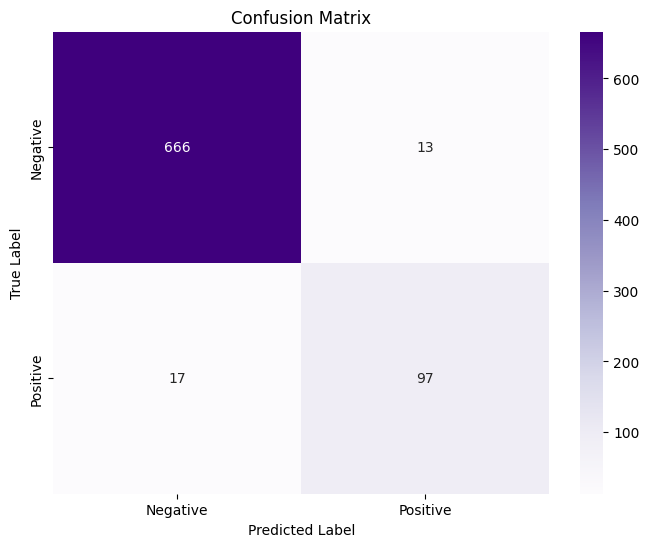


Classification Report:
              precision    recall  f1-score   support

    Negative       0.98      0.98      0.98       679
    Positive       0.88      0.85      0.87       114

    accuracy                           0.96       793
   macro avg       0.93      0.92      0.92       793
weighted avg       0.96      0.96      0.96       793



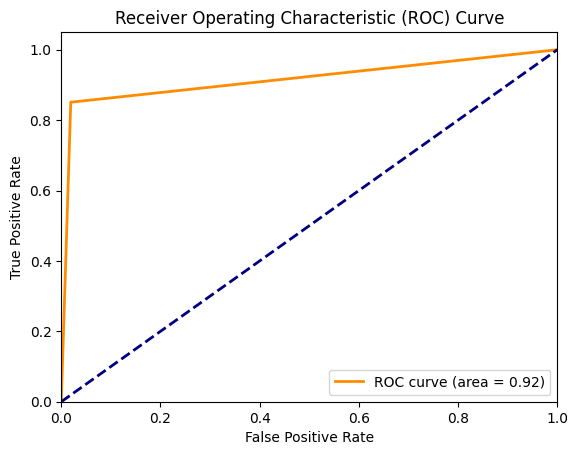


Wrongly Classified Reviews:
True Label: Negative
Predicted Label: Positive
Review: the action scenes are intense and impactful some may find

True Label: Negative
Predicted Label: Positive
Review: the action is thrilling but the plot feels somewhat weak the balance is not quite there

True Label: Positive
Predicted Label: Negative
Review: the twist in the plot

True Label: Positive
Predicted Label: Negative
Review: the twist

True Label: Negative
Predicted Label: Positive
Review: while avengers endgame has its moments of brilliance the

True Label: Negative
Predicted Label: Positive
Review: while avengers endgame has its moments of brilliance it stumbles in maintaining a consistent narrative flow some plot points feel rushed leaving certain character arcs underemployed despite these shortcomings the film delivers on the spectacle with action

True Label: Negative
Predicted Label: Positive
Review: while avengers endgame has its moments of brilliance the balance between thrilling action

In [205]:
# Evaluation
evaluate_classification_results(X_test_original, y_test_original)

### Regression Evaluation

25/25 [==============================] - 0s 962us/step
Regression Model Evaluation Results:
R^2 Score: 84.37%
Mean Squared Error (MSE): 0.0074
Mean Absolute Error (MAE): 0.0479


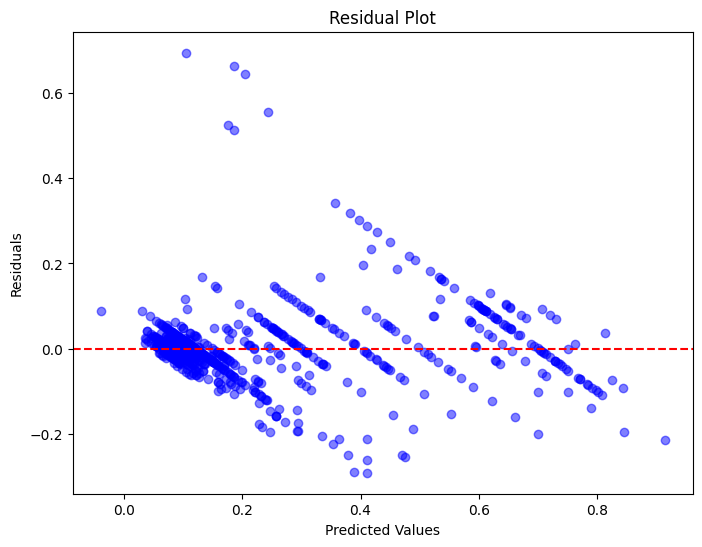

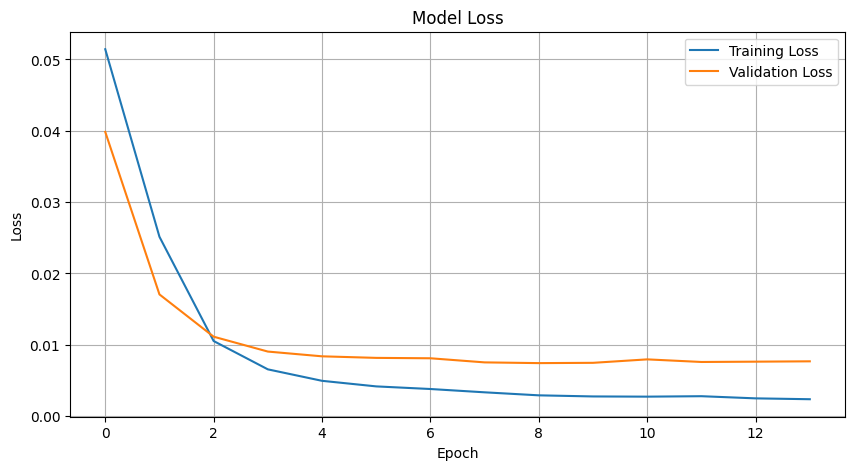

Top 10 Examples with the Furthest Score Differences:
Example 1:
Actual Sentiment Score: 0.8
Predicted Sentiment Score: 0.106
Difference: 0.694
Sentence: this film is very

Example 2:
Actual Sentiment Score: 0.85
Predicted Sentiment Score: 0.186
Difference: 0.664
Sentence: avengers endgame

Example 3:
Actual Sentiment Score: 0.85
Predicted Sentiment Score: 0.205
Difference: 0.645
Sentence: avengers endgame is

Example 4:
Actual Sentiment Score: 0.8
Predicted Sentiment Score: 0.244
Difference: 0.556
Sentence: this film is highly

Example 5:
Actual Sentiment Score: 0.7
Predicted Sentiment Score: 0.176
Difference: 0.524
Sentence: confusing twists

Example 6:
Actual Sentiment Score: 0.7
Predicted Sentiment Score: 0.186
Difference: 0.514
Sentence: avengers endgame

Example 7:
Actual Sentiment Score: 0.7
Predicted Sentiment Score: 0.357
Difference: 0.343
Sentence: the twist

Example 8:
Actual Sentiment Score: 0.7
Predicted Sentiment Score: 0.382
Difference: 0.318
Sentence: the actors

Example

In [206]:
# Evaluation
evaluate_regression_results(X_test_original, y_test_original, history)

## Simple Embedding model with augmented data
- Using Augmented Data instead of Original Data to see which one will increase the performance of the model.

### Modelling

In [207]:
# Create model
model = Sequential()
model.add(Embedding(total_words_augmented, 32, input_length=max_sequence_len_augmented))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='linear'))

# Compile model
model.compile(loss='mean_squared_error',
              optimizer='adam')  

# View the layer summary
model.summary()

# EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Fit the model
history = model.fit(X_train_augmented, y_train_augmented, 
                    validation_data=(X_test_augmented, y_test_augmented), 
                    epochs=40, batch_size=128, verbose=1, callbacks=[early_stopping])

Model: "sequential_98"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_96 (Embedding)    (None, 58, 32)            58752     
                                                                 
 flatten_5 (Flatten)         (None, 1856)              0         
                                                                 
 dense_101 (Dense)           (None, 256)               475392    
                                                                 
 dense_102 (Dense)           (None, 1)                 257       
                                                                 
Total params: 534,401
Trainable params: 534,401
Non-trainable params: 0
_________________________________________________________________
Epoch 1/40
110/110 [==============================] - 1s 3ms/step - loss: 0.0251 - val_loss: 0.0080
Epoch 2/40
110/110 [==============================] - 0s 3ms/step - loss: 0.006

### Classification Evaluation

110/110 [==============================] - 0s 880us/step
Classification Accuracy: 97.72%



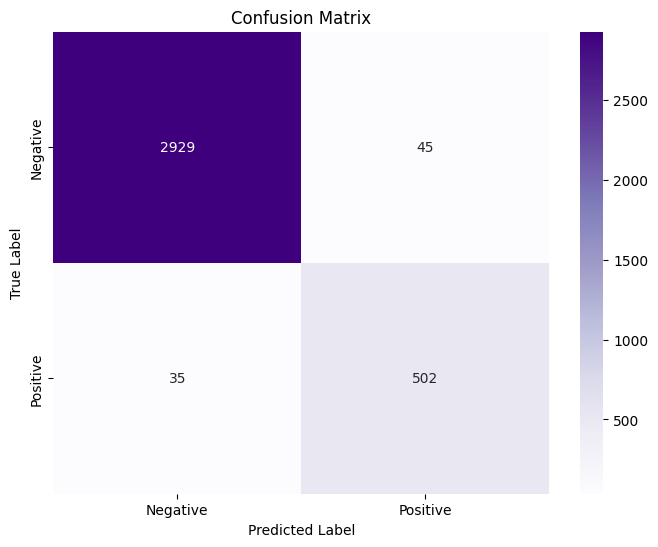


Classification Report:
              precision    recall  f1-score   support

    Negative       0.99      0.98      0.99      2974
    Positive       0.92      0.93      0.93       537

    accuracy                           0.98      3511
   macro avg       0.95      0.96      0.96      3511
weighted avg       0.98      0.98      0.98      3511



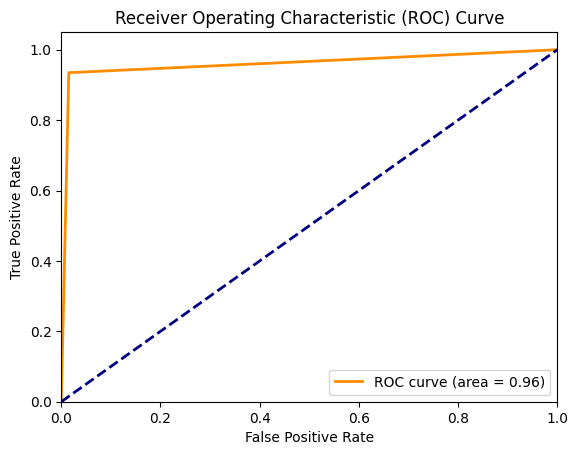


Wrongly Classified Reviews:
True Label: Positive
Predicted Label: Negative
Review: straight story

True Label: Positive
Predicted Label: Negative
Review: an loose all

True Label: Negative
Predicted Label: Positive
Review: despite its ambitious narrative avenger endgame stumbles with pacing issues will some moments smell rushed

True Label: Negative
Predicted Label: Positive
Review: while avengers endgame has its moments of grandness the balance between electrifying action and a cohesive

True Label: Positive
Predicted Label: Negative
Review: the twist in the plot of

True Label: Positive
Predicted Label: Negative
Review: improbable playacting

True Label: Negative
Predicted Label: Positive
Review: while avengers end game has its moments of brilliance it stumbles in maintaining a consistent narrative flow some plot points smell

True Label: Negative
Predicted Label: Positive
Review: while avengers endgame has its moments

True Label: Negative
Predicted Label: Positive
Review: over the

In [208]:
# Evaluation
evaluate_classification_results(X_test_augmented, y_test_augmented)

### Regression Evaluation

110/110 [==============================] - 0s 762us/step
Regression Model Evaluation Results:
R^2 Score: 91.74%
Mean Squared Error (MSE): 0.0042
Mean Absolute Error (MAE): 0.0280


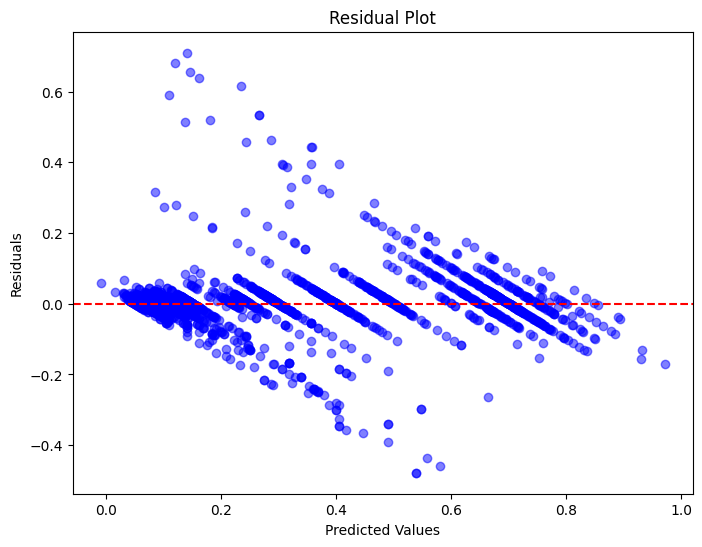

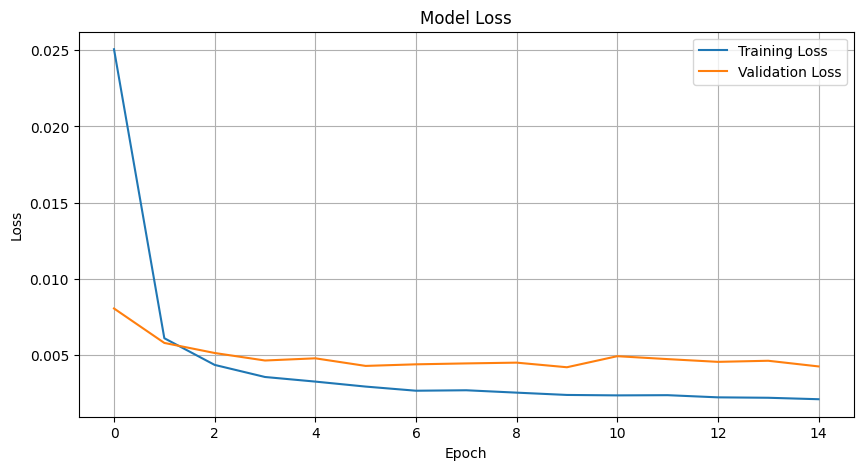

Top 10 Examples with the Furthest Score Differences:
Example 1:
Actual Sentiment Score: 0.85
Predicted Sentiment Score: 0.140
Difference: 0.710
Sentence: avengers endgame

Example 2:
Actual Sentiment Score: 0.8
Predicted Sentiment Score: 0.119
Difference: 0.681
Sentence: this moving picture show

Example 3:
Actual Sentiment Score: 0.8
Predicted Sentiment Score: 0.146
Difference: 0.654
Sentence: this movie

Example 4:
Actual Sentiment Score: 0.8
Predicted Sentiment Score: 0.161
Difference: 0.639
Sentence: this film

Example 5:
Actual Sentiment Score: 0.85
Predicted Sentiment Score: 0.235
Difference: 0.615
Sentence: endgame avengers

Example 6:
Actual Sentiment Score: 0.7
Predicted Sentiment Score: 0.109
Difference: 0.591
Sentence: an loose

Example 7:
Actual Sentiment Score: 0.8
Predicted Sentiment Score: 0.266
Difference: 0.534
Sentence: this movie is very

Example 8:
Actual Sentiment Score: 0.8
Predicted Sentiment Score: 0.266
Difference: 0.534
Sentence: this movie is very

Example 9:

In [209]:
# Evaluation
evaluate_regression_results(X_test_augmented, y_test_augmented, history)

## Using LSTM 

Explanation
- Long Short-Term Memory (LSTM) includes gating mechanisms such as forget gate that allow them to control the flow of information and gradients through the network, preventing the gradients from becoming too small and vanishing. (Vanishing gradient problem includes slow convergence, difficulty in training networks).
- LSTM is made of 4 main components, the forget gate (how much infomation to retain), the input gate (how much new infomation to be added), the output gate (how much information is produced) and the cell state (represents the memory and includes the current and previous step).
- LSTM can capture information from earlier time steps and remember it for a more extended period using its memory cell hence making them effective NLP.

Reference: https://www.knowledgehut.com/blog/web-development/long-short-term-memory#long-short-term%C2%A0memory-networks

### Modelling

In [26]:
from tensorflow.keras.layers import LSTM

# Create model
model = Sequential()
model.add(Embedding(total_words_augmented, 32, input_length=max_sequence_len_augmented))
model.add(LSTM(256)) 
model.add(Dropout(0.25))
model.add(Dense(1, activation='linear'))

# Compile model
model.compile(loss='mean_squared_error',
              optimizer='adam')  

# View the layer summary
model.summary()

# EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Fit the model
history = model.fit(X_train_augmented, y_train_augmented, 
                    validation_data=(X_test_augmented, y_test_augmented), 
                    epochs=40, batch_size=128, verbose=1, callbacks=[early_stopping])

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 58, 32)            58752     
                                                                 
 lstm (LSTM)                 (None, 256)               295936    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_4 (Dense)             (None, 1)                 257       
                                                                 
Total params: 354,945
Trainable params: 354,945
Non-trainable params: 0
_________________________________________________________________
Epoch 1/40
110/110 [==============================] - 3s 10ms/step - loss: 0.0265 - val_loss: 0.0099
Epoch 2/40
110/110 [==============================] - 1s 7ms/step - loss: 0.008

### Classification Evaluation

110/110 [==============================] - 1s 2ms/step
Classification Accuracy: 98.03%



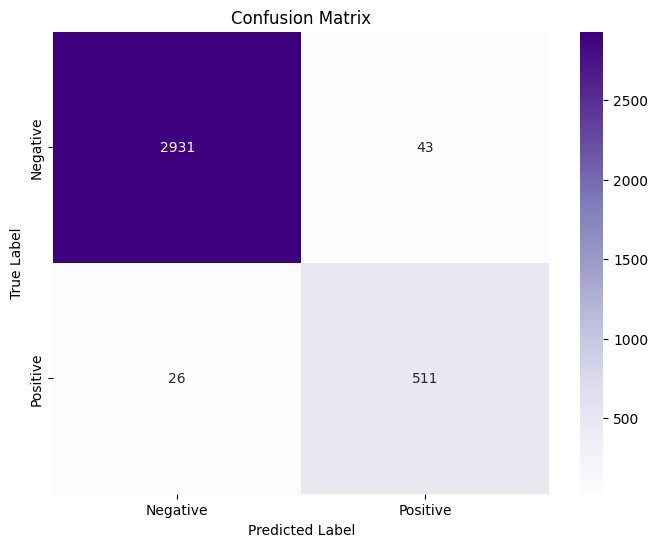


Classification Report:
              precision    recall  f1-score   support

    Negative       0.99      0.99      0.99      2974
    Positive       0.92      0.95      0.94       537

    accuracy                           0.98      3511
   macro avg       0.96      0.97      0.96      3511
weighted avg       0.98      0.98      0.98      3511



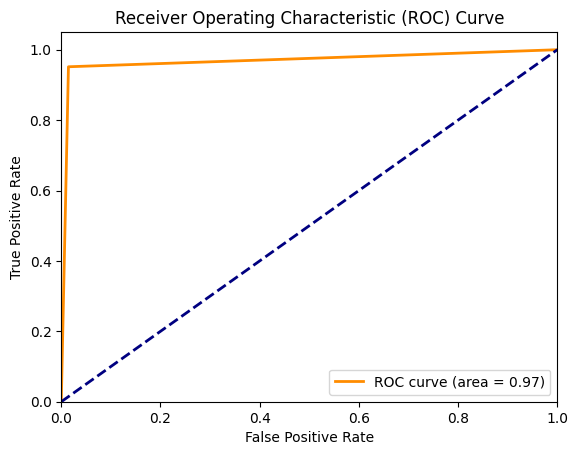


Wrongly Classified Reviews:
True Label: Positive
Predicted Label: Negative
Review: straight story

True Label: Negative
Predicted Label: Positive
Review: while avengers endgame has its instant of brilliance the balance between thrilling action and a cohesive plot of ground feels somewhat skewed some action vista whitethorn overshadow the narrative impacting the

True Label: Negative
Predicted Label: Positive
Review: while avengers endgame has its instant of brilliance the balance between thrilling action and a cohesive plot of ground feels somewhat skewed some action vista whitethorn overshadow the narrative impacting the overall tempo a more harmonious blend would have elevated the film even

True Label: Negative
Predicted Label: Positive
Review: while avengers end game has its moments of brilliance it stumbles in maintaining a consistent narrative flow some plot points smell rushed leaving certain grapheme arcs underemployed despite these shortcomings the film delivers on the specta

In [27]:
# Evaluation
evaluate_classification_results(X_test_augmented, y_test_augmented)

### Regression Evaluation

110/110 [==============================] - 0s 2ms/step
Regression Model Evaluation Results:
R^2 Score: 93.34%
Mean Squared Error (MSE): 0.0034
Mean Absolute Error (MAE): 0.0262


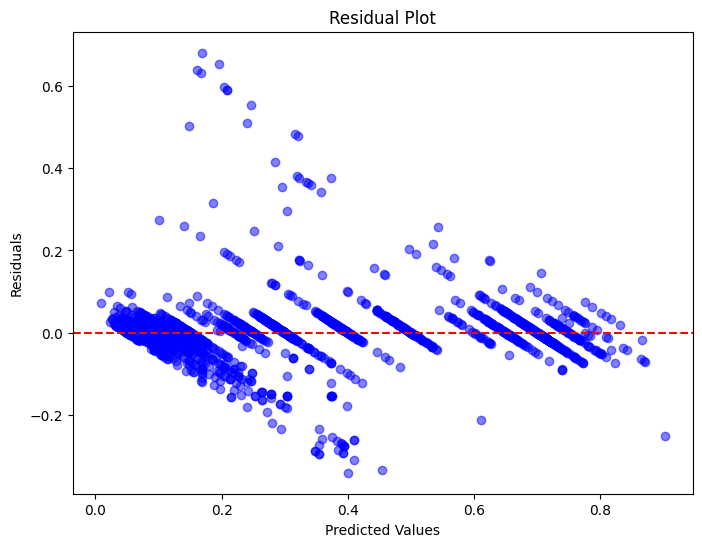

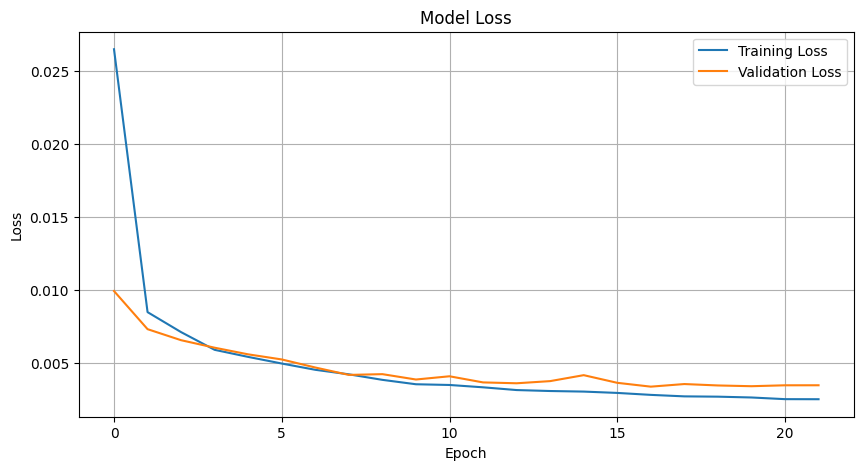

Top 10 Examples with the Furthest Score Differences:
Example 1:
Actual Sentiment Score: 0.85
Predicted Sentiment Score: 0.169
Difference: 0.681
Sentence: avengers endgame

Example 2:
Actual Sentiment Score: 0.85
Predicted Sentiment Score: 0.196
Difference: 0.654
Sentence: endgame avengers

Example 3:
Actual Sentiment Score: 0.8
Predicted Sentiment Score: 0.160
Difference: 0.640
Sentence: this movie

Example 4:
Actual Sentiment Score: 0.8
Predicted Sentiment Score: 0.168
Difference: 0.632
Sentence: this film

Example 5:
Actual Sentiment Score: 0.8
Predicted Sentiment Score: 0.203
Difference: 0.597
Sentence: this moving picture show

Example 6:
Actual Sentiment Score: 0.8
Predicted Sentiment Score: 0.209
Difference: 0.591
Sentence: this movie is very

Example 7:
Actual Sentiment Score: 0.8
Predicted Sentiment Score: 0.209
Difference: 0.591
Sentence: this movie is very

Example 8:
Actual Sentiment Score: 0.8
Predicted Sentiment Score: 0.246
Difference: 0.554
Sentence: this film is very

E

In [28]:
# Evaluation
evaluate_regression_results(X_test_augmented, y_test_augmented, history)

## Using Bidirectional LSTM

Explanation
- Unlike LSTM which read input sequentially from left to right and consider past information, bidirectional LSTMs are able to read input in both directions which allows them to capture context from both the past and the future.
- It has forward pass (similar to LSTM start to end), backward pass (end to start) and concatentation after both passes are completed to create a representation at each time step from pass and future contexts.

Reference: https://www.knowledgehut.com/blog/web-development/long-short-term-memory#long-short-term%C2%A0memory-networks

### Modelling

In [216]:
from tensorflow.keras.layers import Bidirectional

# Create model
model = Sequential()
model.add(Embedding(total_words_augmented, 32, input_length=max_sequence_len_augmented))
model.add(Bidirectional(LSTM(256)))
model.add(Dropout(0.25))
model.add(Dense(1, activation='linear'))

# Compile model
model.compile(loss='mean_squared_error',
              optimizer='adam')  

# View the layer summary
model.summary()

# EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Fit the model
history = model.fit(X_train_augmented, y_train_augmented, 
                    validation_data=(X_test_augmented, y_test_augmented), 
                    epochs=40, batch_size=128, verbose=1, callbacks=[early_stopping])

Model: "sequential_101"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_99 (Embedding)    (None, 58, 32)            58752     
                                                                 
 bidirectional_5 (Bidirectio  (None, 512)              591872    
 nal)                                                            
                                                                 
 dropout_97 (Dropout)        (None, 512)               0         
                                                                 
 dense_105 (Dense)           (None, 1)                 513       
                                                                 
Total params: 651,137
Trainable params: 651,137
Non-trainable params: 0
_________________________________________________________________
Epoch 1/40
110/110 [==============================] - 4s 17ms/step - loss: 0.0259 - val_loss: 0.0107
Epoch 2/40


### Classification Evaluation

110/110 [==============================] - 1s 5ms/step
Classification Accuracy: 98.32%



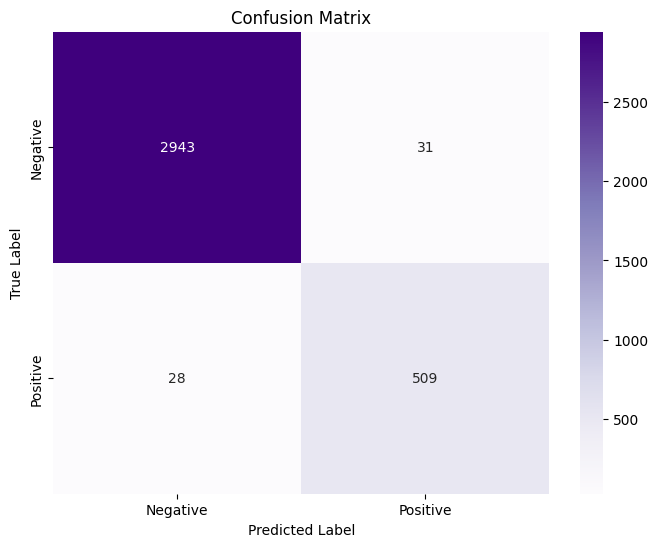


Classification Report:
              precision    recall  f1-score   support

    Negative       0.99      0.99      0.99      2974
    Positive       0.94      0.95      0.95       537

    accuracy                           0.98      3511
   macro avg       0.97      0.97      0.97      3511
weighted avg       0.98      0.98      0.98      3511



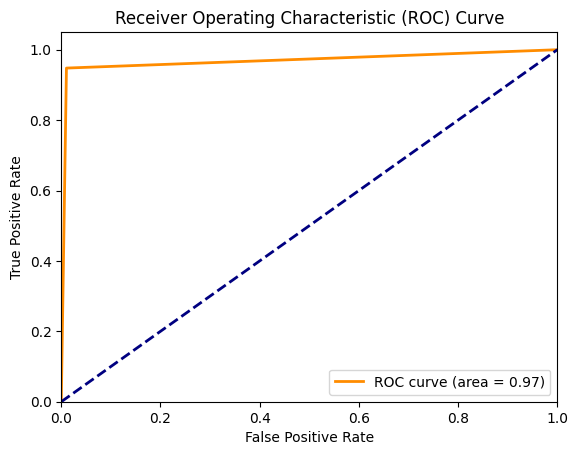


Wrongly Classified Reviews:
True Label: Positive
Predicted Label: Negative
Review: straight story

True Label: Negative
Predicted Label: Positive
Review: despite its ambitious narrative avenger endgame stumbles with pacing issues will some moments smell rushed

True Label: Negative
Predicted Label: Positive
Review: while avengers endgame has its moments of grandness the balance between electrifying action and a cohesive

True Label: Positive
Predicted Label: Negative
Review: the twist in the plot of

True Label: Positive
Predicted Label: Negative
Review: i am

True Label: Positive
Predicted Label: Negative
Review: improbable playacting

True Label: Positive
Predicted Label: Negative
Review: dramatic and

True Label: Negative
Predicted Label: Positive
Review: over the main

True Label: Positive
Predicted Label: Negative
Review: endgame avengers

True Label: Negative
Predicted Label: Positive
Review: despite its ambitious narrative avengers endgame stumbles with pacing issues leaving so

In [217]:
# Evaluation
evaluate_classification_results(X_test_augmented, y_test_augmented)

### Regression Evaluation

110/110 [==============================] - 1s 5ms/step
Regression Model Evaluation Results:
R^2 Score: 93.18%
Mean Squared Error (MSE): 0.0035
Mean Absolute Error (MAE): 0.0259


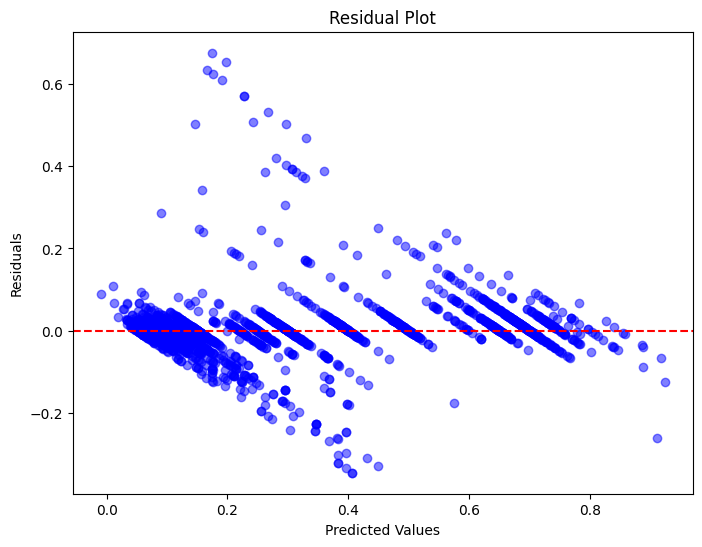

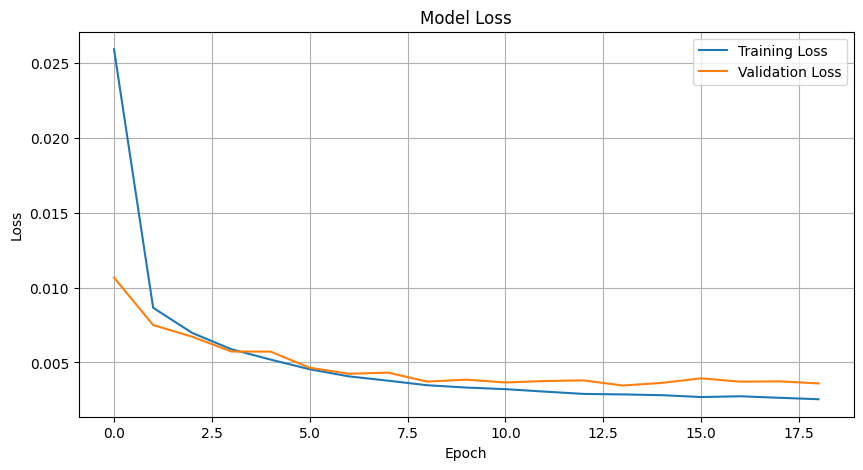

Top 10 Examples with the Furthest Score Differences:
Example 1:
Actual Sentiment Score: 0.85
Predicted Sentiment Score: 0.174
Difference: 0.676
Sentence: avengers endgame

Example 2:
Actual Sentiment Score: 0.85
Predicted Sentiment Score: 0.197
Difference: 0.653
Sentence: endgame avengers

Example 3:
Actual Sentiment Score: 0.8
Predicted Sentiment Score: 0.166
Difference: 0.634
Sentence: this movie

Example 4:
Actual Sentiment Score: 0.8
Predicted Sentiment Score: 0.176
Difference: 0.624
Sentence: this film

Example 5:
Actual Sentiment Score: 0.8
Predicted Sentiment Score: 0.191
Difference: 0.609
Sentence: this moving picture show

Example 6:
Actual Sentiment Score: 0.8
Predicted Sentiment Score: 0.228
Difference: 0.572
Sentence: this movie is very

Example 7:
Actual Sentiment Score: 0.8
Predicted Sentiment Score: 0.228
Difference: 0.572
Sentence: this movie is very

Example 8:
Actual Sentiment Score: 0.8
Predicted Sentiment Score: 0.268
Difference: 0.532
Sentence: this film is very

E

In [218]:
# Evaluation
evaluate_regression_results(X_test_augmented, y_test_augmented, history)

## Using GRU

Explaination
- Gated Recurrent Unit (GRU) is similar to LSTM but it has fewer parameters, hence making them computationally less expensive and faster to train.
- It can handle long-term dependencies in sequential data by selectively remembering and forgetting previous inputs.
- GRU has two gates, update gate which will determine how much past information to be passed along to the future and reset gate which will determine which information should be forgotten or reset.

Reference: https://medium.com/@anishnama20/understanding-gated-recurrent-unit-gru-in-deep-learning-2e54923f3e2

### Modelling

In [213]:
from tensorflow.keras.layers import GRU

# Create model
model = Sequential()
model.add(Embedding(total_words_augmented, 32, input_length=max_sequence_len_augmented))
model.add(GRU(256)) 
model.add(Dropout(0.25))
model.add(Dense(1, activation='linear'))

# Compile model
model.compile(loss='mean_squared_error',
              optimizer='adam')  

# View the layer summary
model.summary()

# EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Fit the model
history = model.fit(X_train_augmented, y_train_augmented, 
                    validation_data=(X_test_augmented, y_test_augmented), 
                    epochs=40, batch_size=128, verbose=1, callbacks=[early_stopping])

Model: "sequential_100"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_98 (Embedding)    (None, 58, 32)            58752     
                                                                 
 gru_85 (GRU)                (None, 256)               222720    
                                                                 
 dropout_96 (Dropout)        (None, 256)               0         
                                                                 
 dense_104 (Dense)           (None, 1)                 257       
                                                                 
Total params: 281,729
Trainable params: 281,729
Non-trainable params: 0
_________________________________________________________________
Epoch 1/40
110/110 [==============================] - 2s 12ms/step - loss: 0.0269 - val_loss: 0.0112
Epoch 2/40
110/110 [==============================] - 1s 7ms/step - loss: 0.0

### Classification Evaluation

110/110 [==============================] - 0s 2ms/step
Classification Accuracy: 98.97%



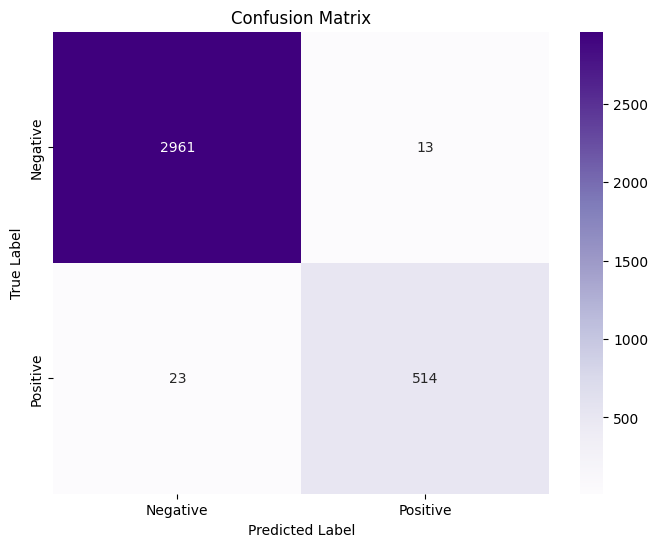


Classification Report:
              precision    recall  f1-score   support

    Negative       0.99      1.00      0.99      2974
    Positive       0.98      0.96      0.97       537

    accuracy                           0.99      3511
   macro avg       0.98      0.98      0.98      3511
weighted avg       0.99      0.99      0.99      3511



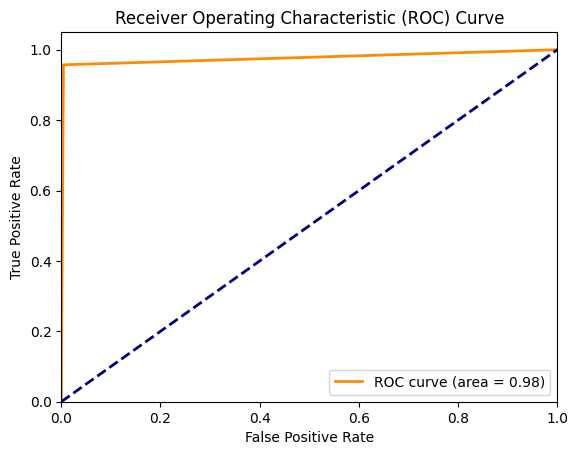


Wrongly Classified Reviews:
True Label: Positive
Predicted Label: Negative
Review: straight story

True Label: Positive
Predicted Label: Negative
Review: the twist in the plot of

True Label: Positive
Predicted Label: Negative
Review: improbable playacting

True Label: Negative
Predicted Label: Positive
Review: while avengers end game has its moments of brilliance it stumbles in maintaining a consistent narrative flow some plot points smell

True Label: Negative
Predicted Label: Positive
Review: over the main

True Label: Positive
Predicted Label: Negative
Review: endgame avengers

True Label: Positive
Predicted Label: Negative
Review: the twist in the plot leaves me

True Label: Negative
Predicted Label: Positive
Review: the action is thrilling but the plot feels

True Label: Positive
Predicted Label: Negative
Review: this film

True Label: Positive
Predicted Label: Negative
Review: the twist in the plot leaves

True Label: Positive
Predicted Label: Negative
Review: the twist in the 

In [214]:
# Evaluation
evaluate_classification_results(X_test_augmented, y_test_augmented)

### Regression Evaluation

110/110 [==============================] - 0s 3ms/step
Regression Model Evaluation Results:
R^2 Score: 93.73%
Mean Squared Error (MSE): 0.0032
Mean Absolute Error (MAE): 0.0215


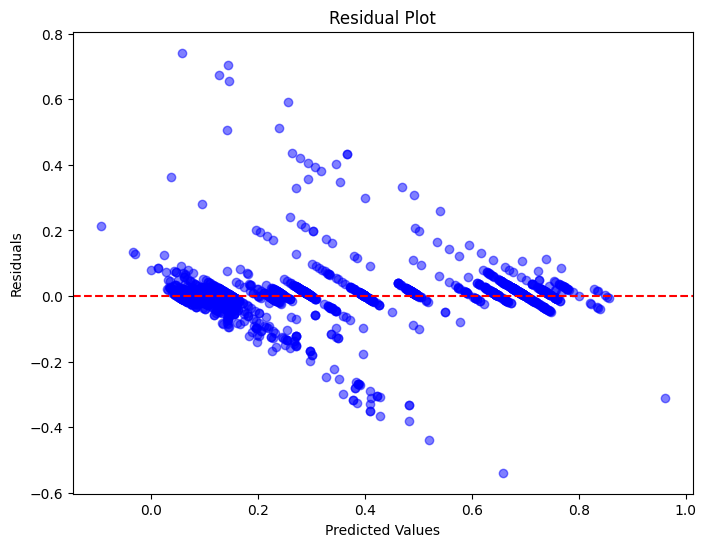

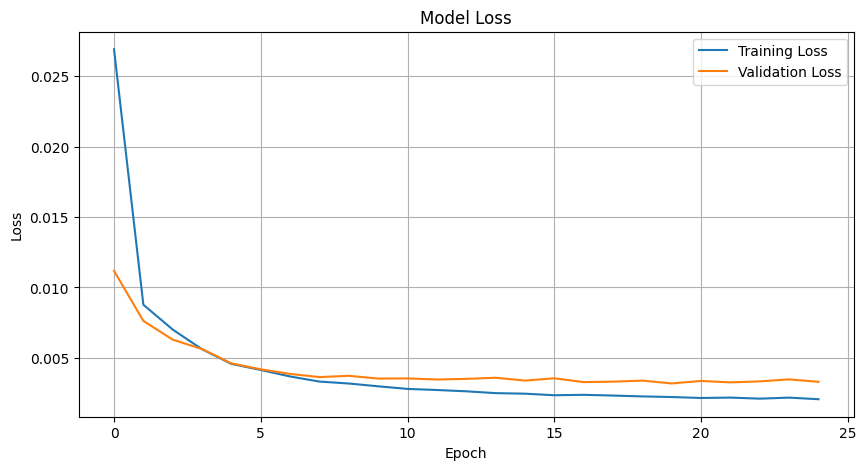

Top 10 Examples with the Furthest Score Differences:
Example 1:
Actual Sentiment Score: 0.8
Predicted Sentiment Score: 0.058
Difference: 0.742
Sentence: this moving picture show

Example 2:
Actual Sentiment Score: 0.85
Predicted Sentiment Score: 0.144
Difference: 0.706
Sentence: avengers endgame

Example 3:
Actual Sentiment Score: 0.8
Predicted Sentiment Score: 0.127
Difference: 0.673
Sentence: this movie

Example 4:
Actual Sentiment Score: 0.8
Predicted Sentiment Score: 0.145
Difference: 0.655
Sentence: this film

Example 5:
Actual Sentiment Score: 0.85
Predicted Sentiment Score: 0.257
Difference: 0.593
Sentence: endgame avengers

Example 6:
Actual Sentiment Score: 0.12
Predicted Sentiment Score: 0.659
Difference: 0.539
Sentence: this flick is

Example 7:
Actual Sentiment Score: 0.75
Predicted Sentiment Score: 0.239
Difference: 0.511
Sentence: improbable playacting

Example 8:
Actual Sentiment Score: 0.65
Predicted Sentiment Score: 0.143
Difference: 0.507
Sentence: the film

Example 9

In [215]:
# Evaluation
evaluate_regression_results(X_test_augmented, y_test_augmented, history)

## Using Bidirectional GRU

Explanation
- Same as bidirectional LSTM but using GRU

### Modelling

In [243]:
from tensorflow.keras.layers import Bidirectional

# Create model
model = Sequential()
model.add(Embedding(total_words_augmented, 32, input_length=max_sequence_len_augmented))
model.add(Bidirectional(GRU(256)))
model.add(Dropout(0.25))
model.add(Dense(1, activation='linear'))

# Compile model
model.compile(loss='mean_squared_error',
              optimizer='adam')  

# View the layer summary
model.summary()

# EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Fit the model
history = model.fit(X_train_augmented, y_train_augmented, 
                    validation_data=(X_test_augmented, y_test_augmented), 
                    epochs=40, batch_size=128, verbose=1, callbacks=[early_stopping])

Model: "sequential_110"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_108 (Embedding)   (None, 58, 32)            58752     
                                                                 
 bidirectional_13 (Bidirecti  (None, 512)              445440    
 onal)                                                           
                                                                 
 dropout_107 (Dropout)       (None, 512)               0         
                                                                 
 dense_114 (Dense)           (None, 1)                 513       
                                                                 
Total params: 504,705
Trainable params: 504,705
Non-trainable params: 0
_________________________________________________________________
Epoch 1/40
110/110 [==============================] - 4s 18ms/step - loss: 0.0282 - val_loss: 0.0105
Epoch 2/40


### Classification Evaluation

110/110 [==============================] - 1s 4ms/step
Classification Accuracy: 98.75%



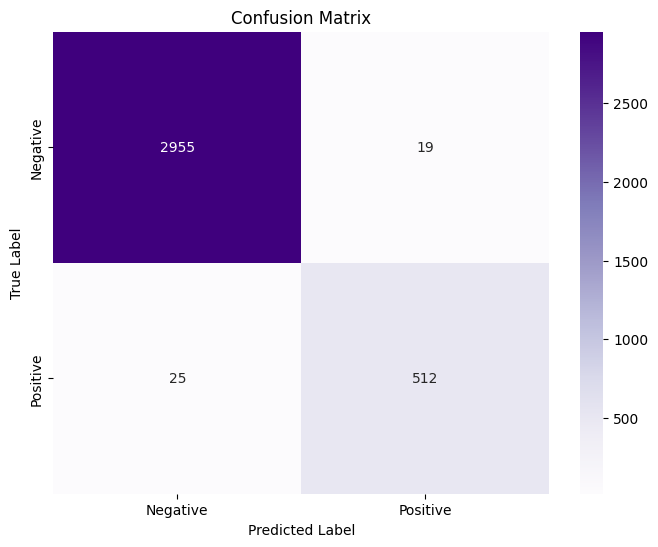


Classification Report:
              precision    recall  f1-score   support

    Negative       0.99      0.99      0.99      2974
    Positive       0.96      0.95      0.96       537

    accuracy                           0.99      3511
   macro avg       0.98      0.97      0.98      3511
weighted avg       0.99      0.99      0.99      3511



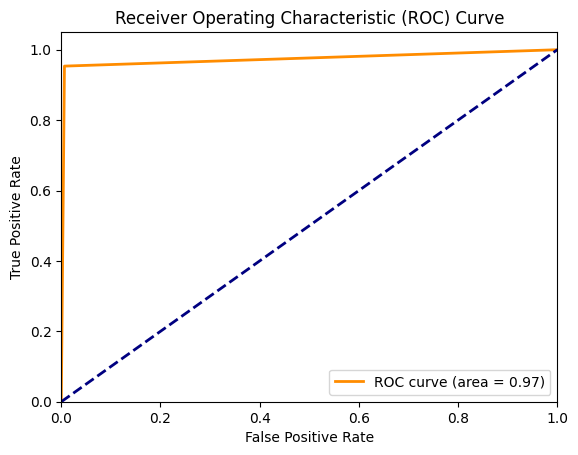


Wrongly Classified Reviews:
True Label: Positive
Predicted Label: Negative
Review: straight story

True Label: Negative
Predicted Label: Positive
Review: while avengers endgame has its instant of brilliance the balance between thrilling action and a cohesive plot of ground feels somewhat skewed some action vista whitethorn overshadow the narrative impacting the overall tempo a more harmonious blend would have elevated the film even

True Label: Positive
Predicted Label: Negative
Review: the twist in the plot of

True Label: Positive
Predicted Label: Negative
Review: improbable playacting

True Label: Positive
Predicted Label: Negative
Review: dramatic and

True Label: Negative
Predicted Label: Positive
Review: the legal action is thrill but

True Label: Negative
Predicted Label: Positive
Review: over the main

True Label: Positive
Predicted Label: Negative
Review: endgame avengers

True Label: Negative
Predicted Label: Positive
Review: the action is thrilling but the plot feels somewh

In [244]:
# Evaluation
evaluate_classification_results(X_test_augmented, y_test_augmented)

### Regression Evaluation

110/110 [==============================] - 0s 4ms/step
Regression Model Evaluation Results:
R^2 Score: 93.65%
Mean Squared Error (MSE): 0.0032
Mean Absolute Error (MAE): 0.0227


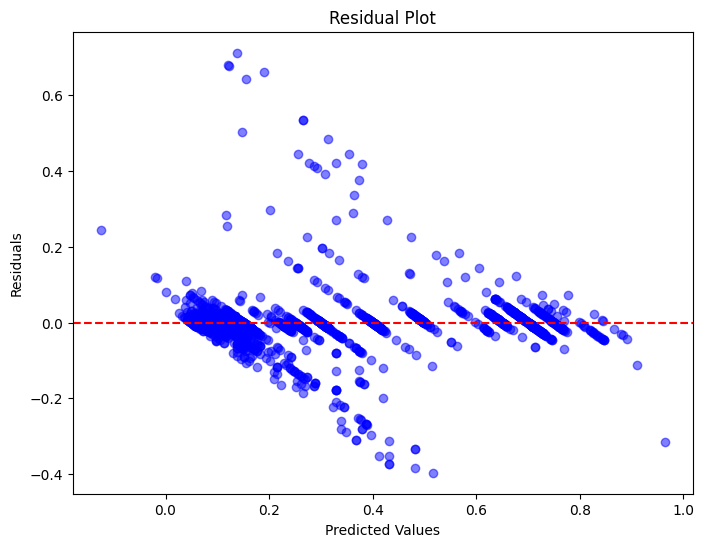

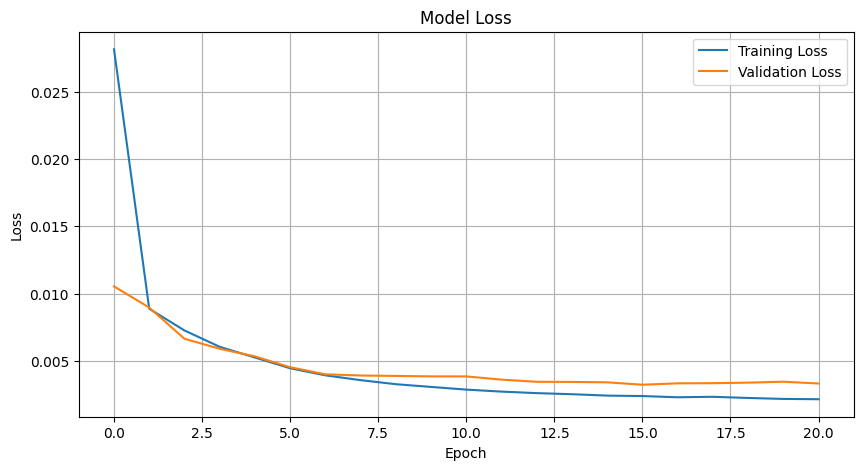

Top 10 Examples with the Furthest Score Differences:
Example 1:
Actual Sentiment Score: 0.85
Predicted Sentiment Score: 0.138
Difference: 0.712
Sentence: avengers endgame

Example 2:
Actual Sentiment Score: 0.8
Predicted Sentiment Score: 0.120
Difference: 0.680
Sentence: this movie

Example 3:
Actual Sentiment Score: 0.8
Predicted Sentiment Score: 0.122
Difference: 0.678
Sentence: this moving picture show

Example 4:
Actual Sentiment Score: 0.85
Predicted Sentiment Score: 0.190
Difference: 0.660
Sentence: endgame avengers

Example 5:
Actual Sentiment Score: 0.8
Predicted Sentiment Score: 0.156
Difference: 0.644
Sentence: this film

Example 6:
Actual Sentiment Score: 0.8
Predicted Sentiment Score: 0.266
Difference: 0.534
Sentence: this movie is very

Example 7:
Actual Sentiment Score: 0.8
Predicted Sentiment Score: 0.266
Difference: 0.534
Sentence: this movie is very

Example 8:
Actual Sentiment Score: 0.65
Predicted Sentiment Score: 0.147
Difference: 0.503
Sentence: the film

Example 9

In [245]:
# Evaluation
evaluate_regression_results(X_test_augmented, y_test_augmented, history)

## Using Stacked GRUs

Explaination
- Stacked gru involves stacking multiple GRU layers on top of each other in modelling.
- It will allow the network to learn hierarchical representation and efficient temporal feature extraction of the input data as each layer stack learns increasingly more features from the input sequence.
- It builds powerful and expressive models for processing sequential data which can improve model perforamnce and generalization capabilities.

Reference: https://www.researchgate.net/figure/The-structure-of-stacked-GRU-The-two-layered-stacked-network-is-used-in-the-proposed_fig5_341841037

### Modelling

In [231]:
# Create model
model = Sequential()
model.add(Embedding(total_words_augmented, 32, input_length=max_sequence_len_augmented))
model.add(GRU(256, return_sequences=True))
model.add(Dropout(0.25))
model.add(GRU(256))
model.add(Dropout(0.25))
model.add(Dense(1, activation='linear'))

# Compile model
model.compile(loss='mean_squared_error',
              optimizer='adam')  

# View the layer summary
model.summary()

# EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Fit the model
history = model.fit(X_train_augmented, y_train_augmented, 
                    validation_data=(X_test_augmented, y_test_augmented), 
                    epochs=40, batch_size=128, verbose=1, callbacks=[early_stopping])

Model: "sequential_106"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_104 (Embedding)   (None, 58, 32)            58752     
                                                                 
 gru_90 (GRU)                (None, 58, 256)           222720    
                                                                 
 dropout_102 (Dropout)       (None, 58, 256)           0         
                                                                 
 gru_91 (GRU)                (None, 256)               394752    
                                                                 
 dropout_103 (Dropout)       (None, 256)               0         
                                                                 
 dense_110 (Dense)           (None, 1)                 257       
                                                                 
Total params: 676,481
Trainable params: 676,481
Non-

### Classification Evaluation

110/110 [==============================] - 1s 4ms/step
Classification Accuracy: 98.18%



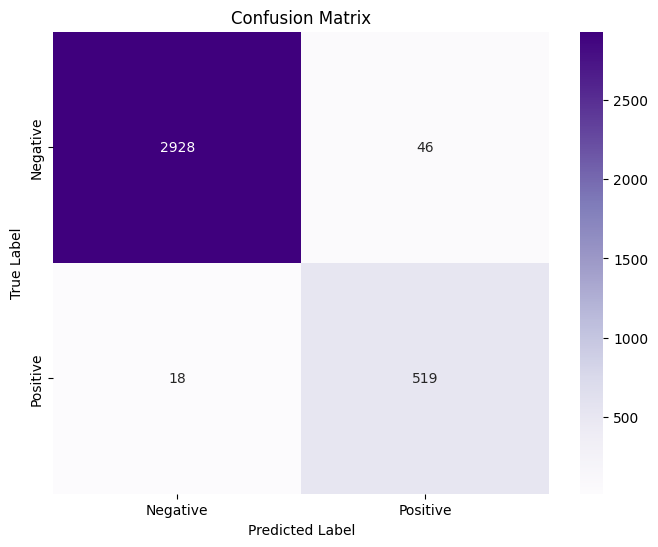


Classification Report:
              precision    recall  f1-score   support

    Negative       0.99      0.98      0.99      2974
    Positive       0.92      0.97      0.94       537

    accuracy                           0.98      3511
   macro avg       0.96      0.98      0.97      3511
weighted avg       0.98      0.98      0.98      3511



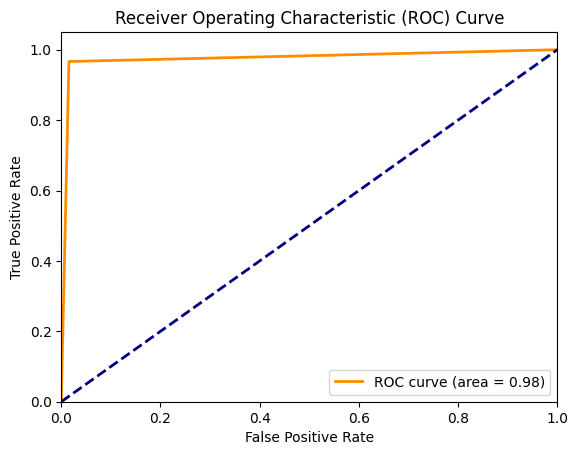


Wrongly Classified Reviews:
True Label: Positive
Predicted Label: Negative
Review: straight story

True Label: Negative
Predicted Label: Positive
Review: despite its ambitious narrative avenger endgame stumbles with pacing issues will some moments smell rushed

True Label: Negative
Predicted Label: Positive
Review: while avengers end game has its moments of brilliance it stumbles in maintaining a consistent narrative flow some plot points smell rushed leaving certain grapheme arcs underemployed despite these shortcomings the film delivers on the spectacle with action successiveness that

True Label: Positive
Predicted Label: Negative
Review: the twist in the plot of

True Label: Positive
Predicted Label: Negative
Review: improbable playacting

True Label: Negative
Predicted Label: Positive
Review: while avengers end game has its moments of brilliance it stumbles in maintaining a consistent narrative flow some plot points smell

True Label: Negative
Predicted Label: Positive
Review: th

In [232]:
# Evaluation
evaluate_classification_results(X_test_augmented, y_test_augmented)

### Regression Evaluation

110/110 [==============================] - 0s 4ms/step
Regression Model Evaluation Results:
R^2 Score: 94.25%
Mean Squared Error (MSE): 0.0029
Mean Absolute Error (MAE): 0.0209


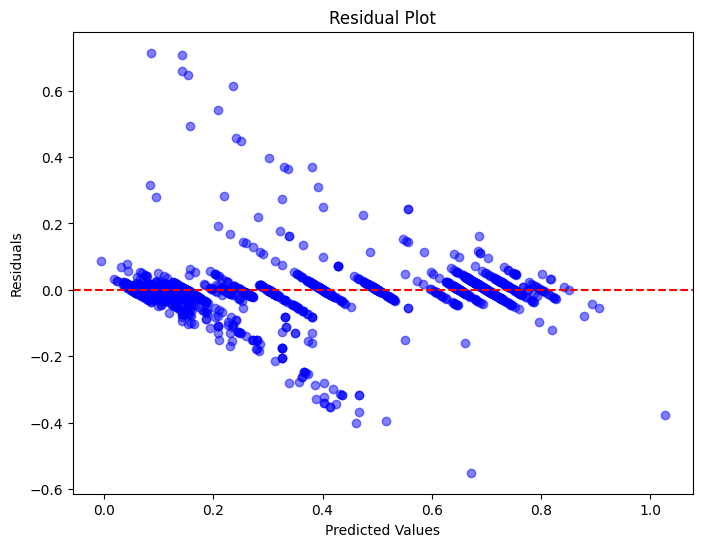

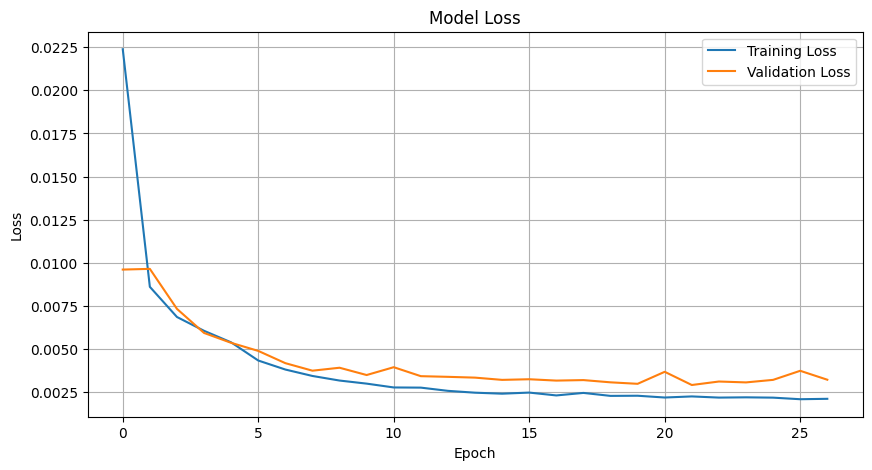

Top 10 Examples with the Furthest Score Differences:
Example 1:
Actual Sentiment Score: 0.8
Predicted Sentiment Score: 0.086
Difference: 0.714
Sentence: this moving picture show

Example 2:
Actual Sentiment Score: 0.85
Predicted Sentiment Score: 0.143
Difference: 0.707
Sentence: avengers endgame

Example 3:
Actual Sentiment Score: 0.8
Predicted Sentiment Score: 0.142
Difference: 0.658
Sentence: this movie

Example 4:
Actual Sentiment Score: 0.8
Predicted Sentiment Score: 0.153
Difference: 0.647
Sentence: this film

Example 5:
Actual Sentiment Score: 0.85
Predicted Sentiment Score: 0.236
Difference: 0.614
Sentence: endgame avengers

Example 6:
Actual Sentiment Score: 0.12
Predicted Sentiment Score: 0.671
Difference: 0.551
Sentence: this flick is

Example 7:
Actual Sentiment Score: 0.75
Predicted Sentiment Score: 0.208
Difference: 0.542
Sentence: improbable playacting

Example 8:
Actual Sentiment Score: 0.65
Predicted Sentiment Score: 0.157
Difference: 0.493
Sentence: the film

Example 9

In [233]:
# Evaluation
evaluate_regression_results(X_test_augmented, y_test_augmented, history)

## Adding GlobalMaxPooling1D

Explaination
- The pooling layer helps in summarizing the sequence information into a fixed-size vector so that it can help in capturing the most relevant information for sentiment analysis.
- It also reduces computational complexity as the sequence is in a fixed-size vector this leading to faster training.

Reference: https://stats.stackexchange.com/questions/257321/what-is-global-max-pooling-layer-and-what-is-its-advantage-over-maxpooling-layer

### Modelling

In [41]:
from tensorflow.keras.layers import GRU, GlobalMaxPool1D

# Create model
model = Sequential()
model.add(Embedding(total_words_augmented, 32, input_length=max_sequence_len_augmented))
model.add(GRU(256, return_sequences=True)) # Set return_sequences=True to return the full sequence
model.add(GlobalMaxPool1D()) 
model.add(Dropout(0.25))
model.add(Dense(1, activation='linear'))

# Compile model
model.compile(loss='mean_squared_error',
              optimizer='adam')  

# View the layer summary
model.summary()

# EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Fit the model
history = model.fit(X_train_augmented, y_train_augmented, 
                    validation_data=(X_test_augmented, y_test_augmented), 
                    epochs=40, batch_size=128, verbose=1, callbacks=[early_stopping])

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 58, 32)            58752     
                                                                 
 gru_4 (GRU)                 (None, 58, 256)           222720    
                                                                 
 global_max_pooling1d (Globa  (None, 256)              0         
 lMaxPooling1D)                                                  
                                                                 
 dropout_6 (Dropout)         (None, 256)               0         
                                                                 
 dense_9 (Dense)             (None, 1)                 257       
                                                                 
Total params: 281,729
Trainable params: 281,729
Non-trainable params: 0
________________________________________________

### Classification Evaluation

110/110 [==============================] - 0s 2ms/step
Classification Accuracy: 98.60%



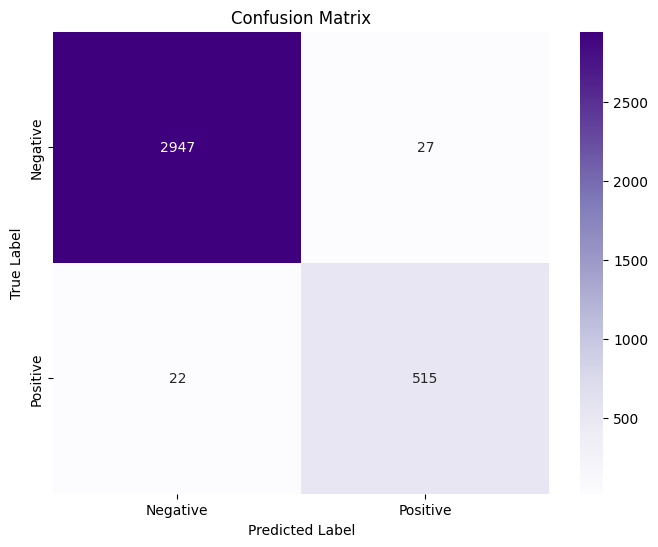


Classification Report:
              precision    recall  f1-score   support

    Negative       0.99      0.99      0.99      2974
    Positive       0.95      0.96      0.95       537

    accuracy                           0.99      3511
   macro avg       0.97      0.97      0.97      3511
weighted avg       0.99      0.99      0.99      3511



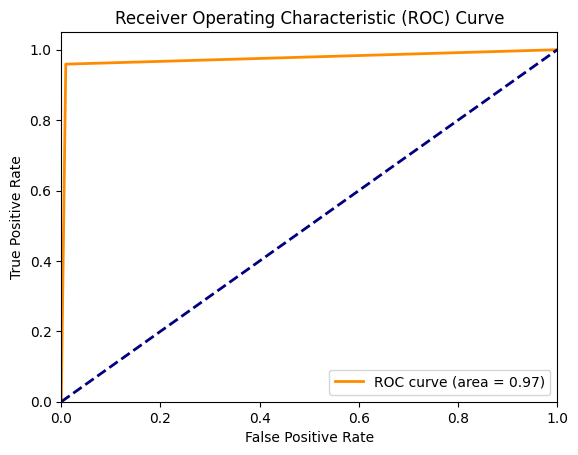


Wrongly Classified Reviews:
True Label: Positive
Predicted Label: Negative
Review: straight story

True Label: Negative
Predicted Label: Positive
Review: despite its ambitious narrative avenger endgame stumbles with pacing issues will some moments smell rushed

True Label: Negative
Predicted Label: Positive
Review: this cinema

True Label: Positive
Predicted Label: Negative
Review: the twist in the plot of

True Label: Positive
Predicted Label: Negative
Review: improbable playacting

True Label: Negative
Predicted Label: Positive
Review: walk out

True Label: Positive
Predicted Label: Negative
Review: endgame avengers

True Label: Negative
Predicted Label: Positive
Review: despite its ambitious narrative avengers endgame stumbles with pacing issues leaving some moments feeling

True Label: Positive
Predicted Label: Negative
Review: this film

True Label: Positive
Predicted Label: Negative
Review: the twist in the plot leaves

True Label: Positive
Predicted Label: Negative
Review: the 

In [42]:
# Evaluation
evaluate_classification_results(X_test_augmented, y_test_augmented)

### Regression Evaluation

110/110 [==============================] - 0s 2ms/step
Regression Model Evaluation Results:
R^2 Score: 94.49%
Mean Squared Error (MSE): 0.0028
Mean Absolute Error (MAE): 0.0191


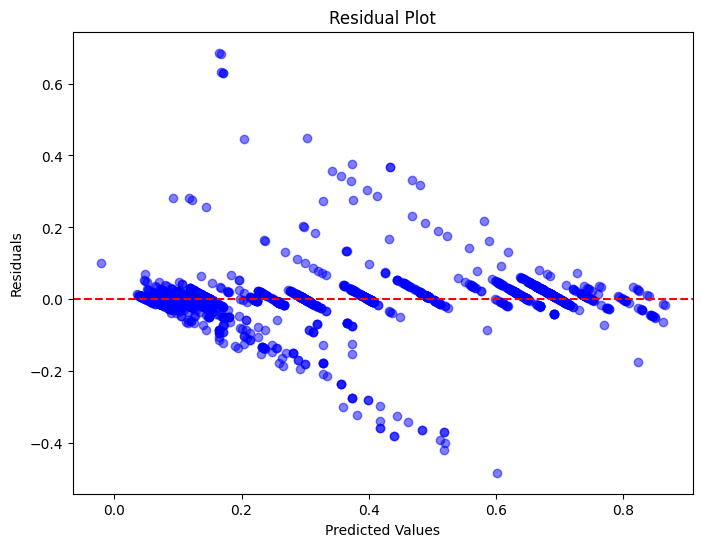

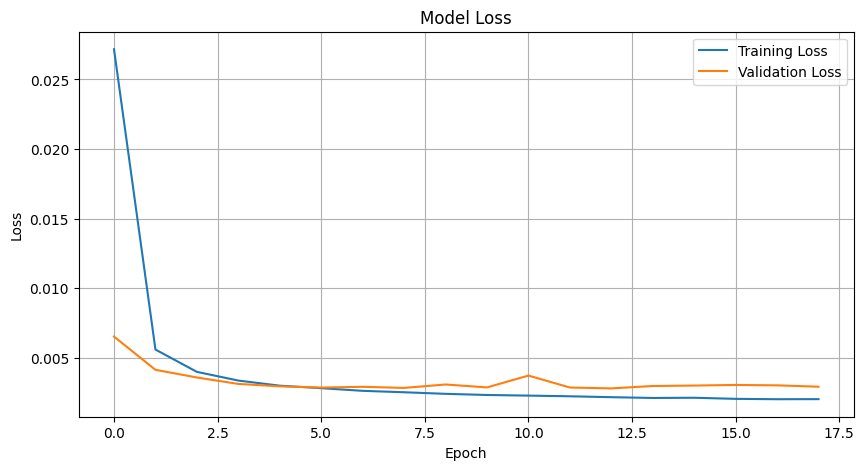

Top 10 Examples with the Furthest Score Differences:
Example 1:
Actual Sentiment Score: 0.85
Predicted Sentiment Score: 0.164
Difference: 0.686
Sentence: avengers endgame

Example 2:
Actual Sentiment Score: 0.85
Predicted Sentiment Score: 0.168
Difference: 0.682
Sentence: endgame avengers

Example 3:
Actual Sentiment Score: 0.8
Predicted Sentiment Score: 0.168
Difference: 0.632
Sentence: this moving picture show

Example 4:
Actual Sentiment Score: 0.8
Predicted Sentiment Score: 0.170
Difference: 0.630
Sentence: this film

Example 5:
Actual Sentiment Score: 0.8
Predicted Sentiment Score: 0.171
Difference: 0.629
Sentence: this movie

Example 6:
Actual Sentiment Score: 0.12
Predicted Sentiment Score: 0.602
Difference: 0.482
Sentence: this flick is

Example 7:
Actual Sentiment Score: 0.75
Predicted Sentiment Score: 0.302
Difference: 0.448
Sentence: improbable playacting

Example 8:
Actual Sentiment Score: 0.65
Predicted Sentiment Score: 0.203
Difference: 0.447
Sentence: the film

Example 9

In [43]:
# Evaluation
evaluate_regression_results(X_test_augmented, y_test_augmented, history)

## Using Attention Mechanism
Attributes
- step_dim: The number of steps (time steps) in the input sequence.
- W_regularizer: Regularizer function applied to the weight matrix W.
- b_regularizer: Regularizer function applied to the bias vector b
- W_constraint: Constraint function applied to the weight matrix W.
- b_constraint: Constraint function applied to the bias vector b.
- bias: Boolean, whether to include a bias term.
- init: Initializer for the weight matrix W.


Explanation
- Attention mechanism enchances models by selectively focusing on the important input elements, improving prediction accuracy and computational efficiency.
- It breaks down the input and picks out the important bits. Then it assigns the importance for each bit and figure out how much attention to give each on and focus on the important ones before putting it all together.
- In the attention layer, there is support for maskingc(handling masked input sequences as there might be padding), weight and bias initializers (Self W is added as a trainable weight to the layer, same as Self b), regularizers (help prevent overfitting), and constraints.
- Computation of attention score (eij) is performed in a call method. The exponential eperation (exp) is applied to eij to get the attention weightws (a).
- Each of these components contributes to the overall functionality and effectiveness of the attention layer in capturing contextually relevant information from input seq

Reference: 
1. https://www.analyticsvidhya.com/blog/2019/11/comprehensive-guide-attention-mechanism-deep-learning/
2. https://www.kaggle.com/code/christofhenkel/keras-baseline-lstm-attention-5-fold (christofhenkel)stofhenkel)nput sequences.

Reference: 
1. https://www.analyticsvidhya.com/blog/2019/11/comprehensive-guide-attention-mechanism-deep-learning/
2. https://www.kaggle.com/code/christofhenkel/keras-baseline-lstm-attention-5-fold (christofhenkel)-fold (christofhenkel)stofhenkel)stofhenkel)tion-5-fold (christofhenkel)

### Modelling

In [65]:
# Define a custom Attention layer
class Attention(Layer):
    def __init__(self, step_dim,
                 W_regularizer=None, b_regularizer=None, W_constraint=None, b_constraint=None,
                 bias=True, **kwargs):
        # Call the constructor of the base class
        super(Attention, self).__init__(**kwargs)
        
        # Set layer attributes
        self.supports_masking = True
        self.init = initializers.get('glorot_uniform')

        self.W_regularizer = regularizers.get(W_regularizer)
        self.b_regularizer = regularizers.get(b_regularizer)

        self.W_constraint = constraints.get(W_constraint)
        self.b_constraint = constraints.get(b_constraint)

        self.bias = bias
        self.step_dim = step_dim
        self.features_dim = 0

    # Method called when the layer is built
    def build(self, input_shape):
        assert len(input_shape) == 3

        # Initialize weight matrix W
        self.W = self.add_weight(shape=(input_shape[-1],), initializer=self.init,
                         name='{}_W'.format(self.name), regularizer=self.W_regularizer,
                         constraint=self.W_constraint)

        self.features_dim = input_shape[-1]

        # Initialize bias vector b if bias=True
        if self.bias:
            self.b = self.add_weight(shape=(input_shape[1],),  
                         initializer='zero', name='{}_b'.format(self.name), 
                         regularizer=self.b_regularizer, constraint=self.b_constraint)
        else:
            self.b = None
            
        self.built = True

    # Method to compute the mask associated with the inputs
    def compute_mask(self, input, input_mask=None):
        return None

    # Method to perform attention mechanism computations
    def call(self, x, mask=None):
        features_dim = self.features_dim
        step_dim = self.step_dim

        # Compute unnormalized attention scores
        eij = K.reshape(K.dot(K.reshape(x, (-1, features_dim)),
                        K.reshape(self.W, (features_dim, 1))), (-1, step_dim))

        # Add bias, if enabled, and apply tanh activation
        if self.bias:
            eij += self.b
        eij = K.tanh(eij)

        # Exponentiate scores to obtain attention weights
        a = K.exp(eij)

        # Apply mask, if provided
        if mask is not None:
            a *= K.cast(mask, K.floatx())
        
        # Normalize attention weights
        a /= K.cast(K.sum(a, axis=1, keepdims=True) + K.epsilon(), K.floatx())

        # Expand dimensions of attention weights and compute weighted input
        a = K.expand_dims(a)
        weighted_input = x * a

        # Sum weighted input across time steps to produce attended output
        return K.sum(weighted_input, axis=1)

    # Method to compute the output shape of the layer
    def compute_output_shape(self, input_shape):
        return input_shape[0],  self.features_dim

# Create model
model = Sequential()
model.add(Embedding(total_words_augmented, 32, input_length=max_sequence_len_augmented))
model.add(GRU(256, return_sequences=True)) 
model.add(Attention(max_sequence_len_augmented))
model.add(Dropout(0.25))
model.add(Dense(1, activation='linear'))

# Compile model
model.compile(loss='mean_squared_error',
              optimizer='adam')  

# View the layer summary
model.summary()

# EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Fit the model
history = model.fit(X_train_augmented, y_train_augmented, 
                    validation_data=(X_test_augmented, y_test_augmented), 
                    epochs=40, batch_size=128, verbose=1, callbacks=[early_stopping])

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_12 (Embedding)    (None, 59, 32)            59104     
                                                                 
 gru_12 (GRU)                (None, 59, 256)           222720    
                                                                 
 attention_10 (Attention)    (None, 256)               315       
                                                                 
 dropout_11 (Dropout)        (None, 256)               0         
                                                                 
 dense_11 (Dense)            (None, 1)                 257       
                                                                 
Total params: 282,396
Trainable params: 282,396
Non-trainable params: 0
_________________________________________________________________
Epoch 1/40
110/110 [===========================

In [66]:
# from tensorflow.keras.layers import GRU, Dense, Dropout, Embedding, Input, Dot, Activation, Concatenate
# from tensorflow.keras.models import Model
# import tensorflow.keras.backend as K

# # Function to compute attention scores
# def attention_score(h, s_prev):
#     return Dot(axes=[2, 1])([h, s_prev])

# # Function to compute attention weights
# def compute_attention_weights(scores):
#     return Activation('softmax')(scores)

# # Function to compute context vector
# def context_vector(h, attention_weights):
#     return Dot(axes=[1, 1])([attention_weights, h])

# # Function to build attention mechanism
# def attention_mechanism(units):
#     h = Input(shape=(None, units,))
#     s_prev = Input(shape=(units,))
    
#     scores = attention_score(h, s_prev)
#     attention_weights = compute_attention_weights(scores)
#     context = context_vector(h, attention_weights)
    
#     return Model(inputs=[h, s_prev], outputs=context)

# # Build attention mechanism
# attention = attention_mechanism(256)

# # Create model
# input_layer = Input(shape=(max_sequence_len_augmented,))
# embedded = Embedding(total_words_augmented, 32, input_length=max_sequence_len_augmented)(input_layer)
# gru_output = GRU(256, return_sequences=True)(embedded)
# context = []
# s_prev = gru_output[:, 0, :]  # Initial s_prev is the first hidden state

# for t in range(1, max_sequence_len_augmented):
#     h_t = gru_output[:, t, :]  # Hidden state at time t
#     context_t = attention([gru_output, s_prev])  # Calculate context vector
#     context.append(context_t)
#     s_prev = context_t  # Update s_prev for next iteration

# context = Concatenate(axis=1)(context)
# dropout = Dropout(0.25)(context)
# output_layer = Dense(1, activation='linear')(dropout)

# model = Model(inputs=input_layer, outputs=output_layer)

# # Compile model
# model.compile(loss='mean_squared_error',
#               optimizer='adam')  

# # View the layer summary
# model.summary()

# # EarlyStopping
# early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# # Fit the model
# history = model.fit(X_train_augmented, y_train_augmented, validation_data=(X_test_augmented, y_test_augmented), 
#                     epochs=40, batch_size=128, verbose=1, callbacks=[early_stopping])

### Classification Evaluation

110/110 [==============================] - 0s 2ms/step
Classification Accuracy: 98.43%



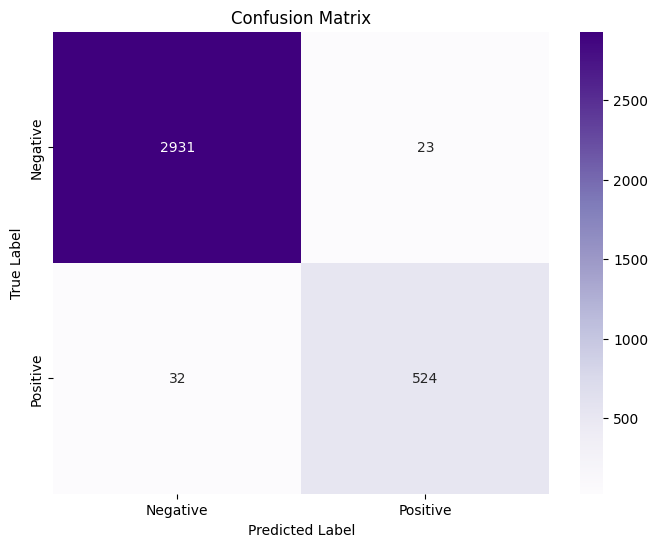


Classification Report:
              precision    recall  f1-score   support

    Negative       0.99      0.99      0.99      2954
    Positive       0.96      0.94      0.95       556

    accuracy                           0.98      3510
   macro avg       0.97      0.97      0.97      3510
weighted avg       0.98      0.98      0.98      3510



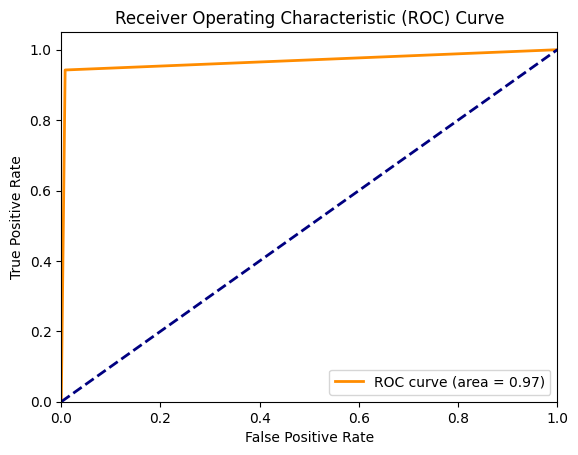


Wrongly Classified Reviews:
True Label: Positive
Predicted Label: Negative
Review: this photographic film

True Label: Positive
Predicted Label: Negative
Review: the twist in the plot

True Label: Positive
Predicted Label: Negative
Review: endgame avengers

True Label: Positive
Predicted Label: Negative
Review: avengers endgame is

True Label: Positive
Predicted Label: Negative
Review: i m

True Label: Negative
Predicted Label: Positive
Review: unexpected turn of events

True Label: Positive
Predicted Label: Negative
Review: retaliator end

True Label: Negative
Predicted Label: Positive
Review: despite its challenging narrative avengers endgame hit with tempo issues going some mo feeling rushed however the film compensates with breathtaking

True Label: Negative
Predicted Label: Positive
Review: while avengers endgame has its moments of brilliance the equilibrize between thrilling action and a cohesive plot feels somewhat skew some action scenery may overshadow the narrative impacting

In [67]:
# Evaluation
evaluate_classification_results(X_test_augmented, y_test_augmented)

### Regression Evaluation

110/110 [==============================] - 0s 3ms/step
Regression Model Evaluation Results:
R^2 Score: 93.14%
Mean Squared Error (MSE): 0.0035
Mean Absolute Error (MAE): 0.0203


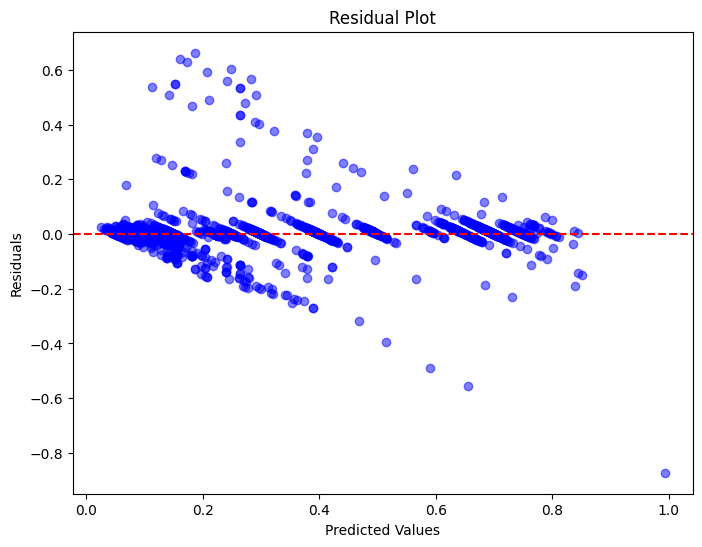

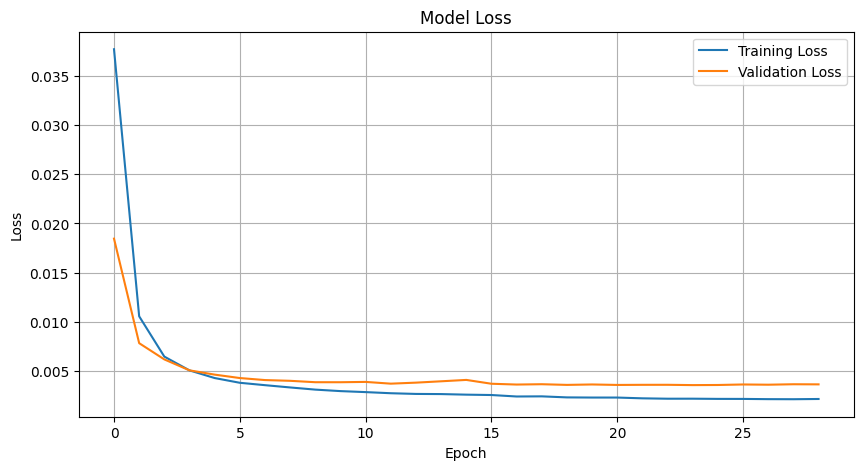

Top 10 Examples with the Furthest Score Differences:
Example 1:
Actual Sentiment Score: 0.12
Predicted Sentiment Score: 0.993
Difference: 0.873
Sentence: run view

Example 2:
Actual Sentiment Score: 0.85
Predicted Sentiment Score: 0.187
Difference: 0.663
Sentence: avengers endgame is

Example 3:
Actual Sentiment Score: 0.8
Predicted Sentiment Score: 0.161
Difference: 0.639
Sentence: this picture show

Example 4:
Actual Sentiment Score: 0.8
Predicted Sentiment Score: 0.173
Difference: 0.627
Sentence: this moving picture is

Example 5:
Actual Sentiment Score: 0.85
Predicted Sentiment Score: 0.248
Difference: 0.602
Sentence: endgame avengers

Example 6:
Actual Sentiment Score: 0.8
Predicted Sentiment Score: 0.207
Difference: 0.593
Sentence: this film is

Example 7:
Actual Sentiment Score: 0.85
Predicted Sentiment Score: 0.284
Difference: 0.566
Sentence: retaliator end

Example 8:
Actual Sentiment Score: 0.8
Predicted Sentiment Score: 0.241
Difference: 0.559
Sentence: this plastic

Example

In [68]:
# Evaluation
evaluate_regression_results(X_test_augmented, y_test_augmented, history)

## Using Pretrained Fasttext Vectors for Word Representation

Explaination
- FastText is an extension of the Word2Vec model, designed to capture subword information in addition to whole-word representations.
- FastText represents each word as a bag of character n-grams. For example, the word "apple" might be represented by the character n-grams {"ap", "app", "appl", "apple", "ppl", "pple", "ple"}.
- FastText computes word embeddings by summing up the embeddings of its constituent character n-grams. This enables the model to generate embeddings for words that are not present in the training data, based on their subword information.
- We use Fasttext because of its ability to capture subword information and efficiently handle out-of-vocabulary words.

References: https://fasttext.cc/docs/en/crawl-vectors.html

### Modelling

In [103]:
from gensim.models import KeyedVectors

# Load FastText vectors using gensim
def load_fasttext_vectors(fasttext_file_path):
    return KeyedVectors.load_word2vec_format(fasttext_file_path, binary=False)

# Load the GloVe and FastText models
fasttext_model = load_fasttext_vectors('Text_representations/wiki-news-300d-1M-subword.vec')

# Initializing 
# If the word exists, it retrieves the corresponding embedding vector using the get_vector method and 
# stores it in the embedding matrix at the appropriate index.
def create_embedding_matrix(vocab, fasttext_model, embedding_dim=300):
    embedding_matrix = np.zeros((len(vocab) + 1, embedding_dim))  # +1 for padding token
    for word, i in vocab.items():
        if word in fasttext_model:
            embedding_vector = fasttext_model.get_vector(word)
            embedding_matrix[i] = embedding_vector
    return embedding_matrix

# Create the embedding matrix
embedding_matrix = create_embedding_matrix(word_index_augmented, fasttext_model, embedding_dim=300)

# Create model
model = Sequential()
model.add(Embedding(input_dim=total_words_augmented, 
                    output_dim=300, 
                    weights=[embedding_matrix], 
                    input_length=max_sequence_len_augmented, 
                    trainable=False))  # Set trainable to False to use the pre-trained embeddings as is
model.add(GRU(256)) 
model.add(Dropout(0.25))
model.add(Dense(1, activation='linear'))

# Compile model
model.compile(loss='mean_squared_error', 
              optimizer='adam')

# View the layer summary
model.summary()

# EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Fit the model with both callbacks
history = model.fit(X_train_augmented, y_train_augmented, 
                    validation_data=(X_test_augmented, y_test_augmented), 
                    epochs=40, batch_size=128, verbose=1, 
                    callbacks=[early_stopping])


Model: "sequential_57"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_57 (Embedding)    (None, 58, 300)           550800    
                                                                 
 gru_57 (GRU)                (None, 256)               428544    
                                                                 
 dropout_59 (Dropout)        (None, 256)               0         
                                                                 
 dense_58 (Dense)            (None, 1)                 257       
                                                                 
Total params: 979,601
Trainable params: 428,801
Non-trainable params: 550,800
_________________________________________________________________
Epoch 1/40
110/110 [==============================] - 2s 9ms/step - loss: 0.0361 - val_loss: 0.0223
Epoch 2/40
110/110 [==============================] - 1s 7ms/step - loss:

### Classification Evaluation

110/110 [==============================] - 0s 2ms/step
Classification Accuracy: 97.38%



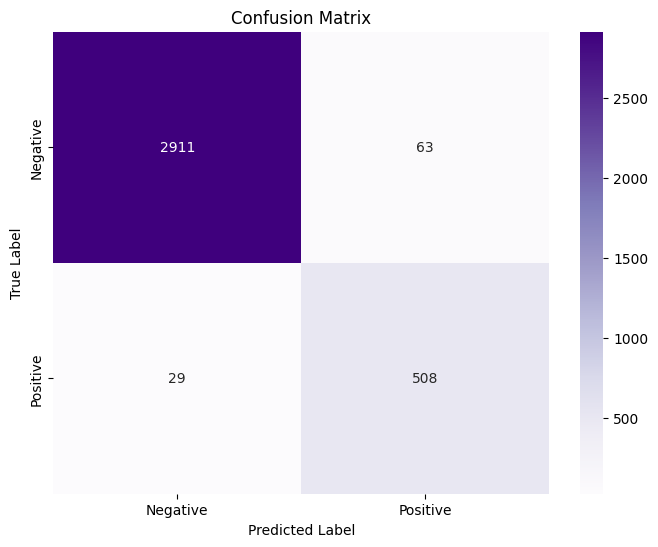


Classification Report:
              precision    recall  f1-score   support

    Negative       0.99      0.98      0.98      2974
    Positive       0.89      0.95      0.92       537

    accuracy                           0.97      3511
   macro avg       0.94      0.96      0.95      3511
weighted avg       0.97      0.97      0.97      3511



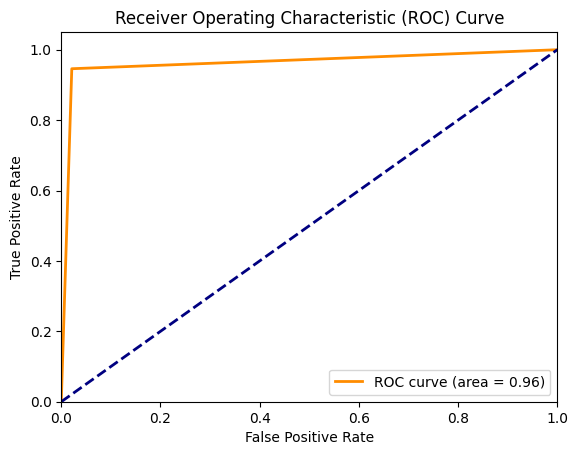


Wrongly Classified Reviews:
True Label: Positive
Predicted Label: Negative
Review: straight story

True Label: Negative
Predicted Label: Positive
Review: despite its ambitious narrative avenger endgame stumbles with pacing issues will some moments smell rushed

True Label: Negative
Predicted Label: Positive
Review: while avengers endgame has its instant of brilliance the balance between thrilling action and a cohesive plot of ground feels somewhat skewed some action vista whitethorn overshadow the narrative impacting the

True Label: Negative
Predicted Label: Positive
Review: while avengers endgame has its instant of brilliance the balance between thrilling action and a cohesive plot of ground feels somewhat skewed some action vista whitethorn overshadow the narrative impacting the overall tempo a more harmonious blend would have elevated the film even

True Label: Negative
Predicted Label: Positive
Review: while avengers endgame is

True Label: Negative
Predicted Label: Positive
Revi

In [104]:
# Evaluation
evaluate_classification_results(X_test_augmented, y_test_augmented) # 98.23

### Regression Evaluation

110/110 [==============================] - 0s 2ms/step
Regression Model Evaluation Results:
R^2 Score: 92.78%
Mean Squared Error (MSE): 0.0037
Mean Absolute Error (MAE): 0.0271


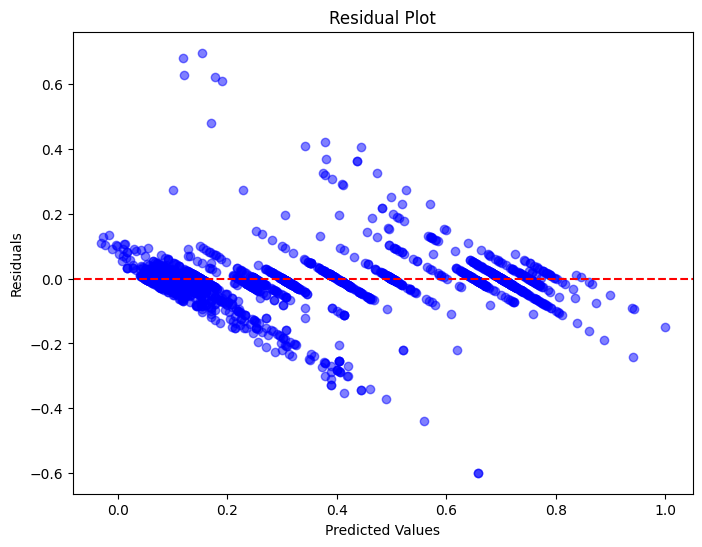

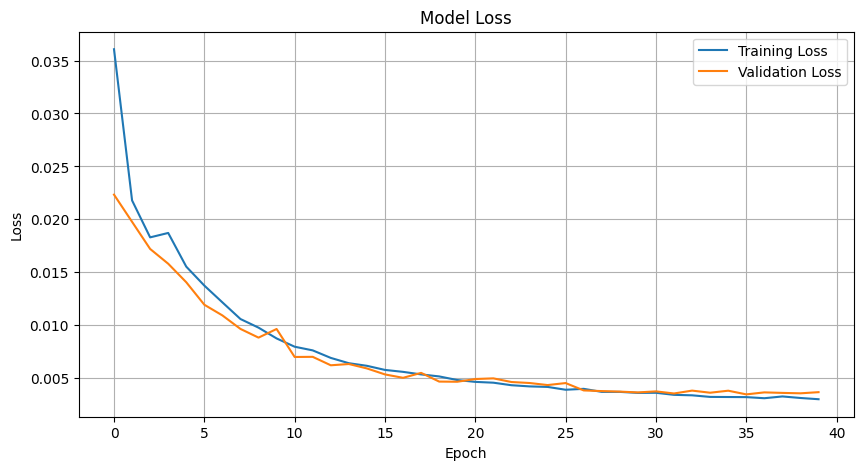

Top 10 Examples with the Furthest Score Differences:
Example 1:
Actual Sentiment Score: 0.85
Predicted Sentiment Score: 0.154
Difference: 0.696
Sentence: avengers endgame

Example 2:
Actual Sentiment Score: 0.8
Predicted Sentiment Score: 0.119
Difference: 0.681
Sentence: this moving picture show

Example 3:
Actual Sentiment Score: 0.75
Predicted Sentiment Score: 0.121
Difference: 0.629
Sentence: improbable playacting

Example 4:
Actual Sentiment Score: 0.8
Predicted Sentiment Score: 0.177
Difference: 0.623
Sentence: this film

Example 5:
Actual Sentiment Score: 0.8
Predicted Sentiment Score: 0.190
Difference: 0.610
Sentence: this movie

Example 6:
Actual Sentiment Score: 0.06
Predicted Sentiment Score: 0.658
Difference: 0.598
Sentence: retaliator endgame is

Example 7:
Actual Sentiment Score: 0.06
Predicted Sentiment Score: 0.658
Difference: 0.598
Sentence: retaliator endgame is

Example 8:
Actual Sentiment Score: 0.65
Predicted Sentiment Score: 0.170
Difference: 0.480
Sentence: the fi

In [105]:
# Evaluation
evaluate_regression_results(X_test_augmented, y_test_augmented, history)

## Using Global Vectors for Word Representation (GloVe)

Explaination
- The GloVe model provides an effective way to measure the semantic similarity between words using vector representations. It uses Euclidean distance or cosine similarity to help identify words that are closely related in meaning.
- GloVe uses vector differences between word pairs. For instance, the difference between "man" and "woman" captures the concept of gender.
- GloVe is trained on the non-zero entries of a word-word co-occurrence matrix, which records how frequently words appear together in a corpus. The training involves a weighted least-squares objective, designed to learn word vectors such that their dot product approximates the logarithm of word co-occurrence probabilities.
- We use GloVe because it is able effectively captures semantic similarity between words and represent complex relationships between words, such as gender distinctions or roles within a company.

References: https://github.com/stanfordnlp/GloVe?tab=readme-ov-file

### Modelling

In [106]:
# Load the glove vectors file
def load_glove_vectors(glove_file_path):
    glove_model = {}
    with open(glove_file_path, 'r', encoding='utf8') as f:
        for line in f:
            split_line = line.split()
            word = split_line[0]
            embedding = np.array([float(val) for val in split_line[1:]])
            glove_model[word] = embedding
    return glove_model

# Load GloVe vectors
glove_model = load_glove_vectors('Text_representations/glove.6B.300d.txt')

# Initializes 
def create_embedding_matrix(vocab, glove_model, embedding_dim=300):
    embedding_matrix = np.zeros((len(vocab) + 1, embedding_dim))  # +1 for padding token
    for word, i in vocab.items():
        embedding_vector = glove_model.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
    return embedding_matrix

# Create the embedding matrix
embedding_matrix = create_embedding_matrix(word_index_augmented, glove_model, embedding_dim=300)

# Create model
model = Sequential()
model.add(Embedding(input_dim=total_words_augmented, 
                    output_dim=300, 
                    weights=[embedding_matrix], 
                    input_length=max_sequence_len_augmented, 
                    trainable=True))  # Set trainable to False to use the pre-trained embeddings as is
model.add(GRU(256)) 
model.add(Dropout(0.25))
model.add(Dense(1, activation='linear'))

# Compile model
model.compile(loss='mean_squared_error', 
              optimizer='adam')

# View the layer summary
model.summary()

# EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)

# Fit the model with both callbacks
history = model.fit(X_train_augmented, y_train_augmented, 
                    validation_data=(X_test_augmented, y_test_augmented), 
                    epochs=40, batch_size=128, verbose=1, 
                    callbacks=[early_stopping])

Model: "sequential_58"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_58 (Embedding)    (None, 58, 300)           550800    
                                                                 
 gru_58 (GRU)                (None, 256)               428544    
                                                                 
 dropout_60 (Dropout)        (None, 256)               0         
                                                                 
 dense_59 (Dense)            (None, 1)                 257       
                                                                 
Total params: 979,601
Trainable params: 979,601
Non-trainable params: 0
_________________________________________________________________
Epoch 1/40
110/110 [==============================] - 2s 10ms/step - loss: 0.0507 - val_loss: 0.0154
Epoch 2/40
110/110 [==============================] - 1s 8ms/step - loss: 0.01

### Classification Evaluation

110/110 [==============================] - 0s 2ms/step
Classification Accuracy: 97.64%



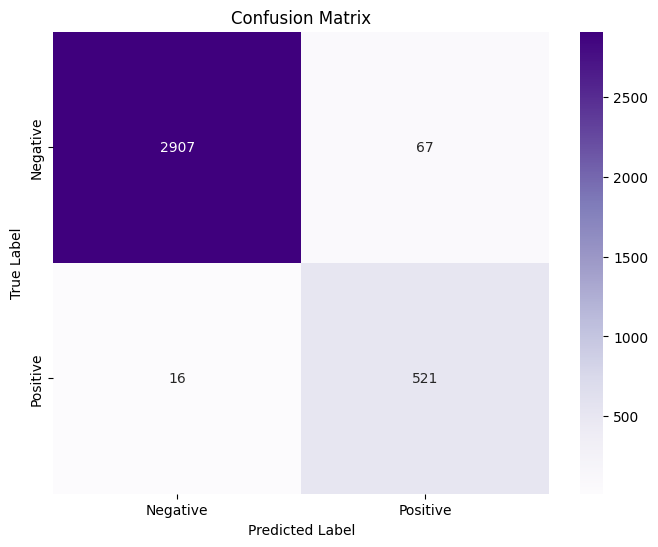


Classification Report:
              precision    recall  f1-score   support

    Negative       0.99      0.98      0.99      2974
    Positive       0.89      0.97      0.93       537

    accuracy                           0.98      3511
   macro avg       0.94      0.97      0.96      3511
weighted avg       0.98      0.98      0.98      3511



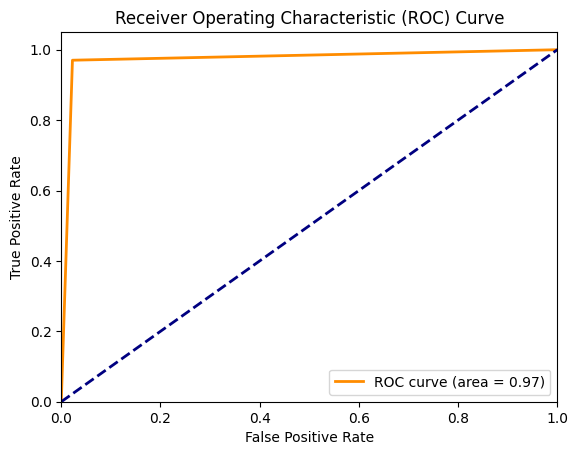


Wrongly Classified Reviews:
True Label: Positive
Predicted Label: Negative
Review: straight story

True Label: Negative
Predicted Label: Positive
Review: despite its ambitious narrative avenger endgame stumbles with pacing issues will some moments smell rushed

True Label: Negative
Predicted Label: Positive
Review: while avengers endgame has its moments of grandness the balance between electrifying action and a cohesive

True Label: Negative
Predicted Label: Positive
Review: this cinema

True Label: Positive
Predicted Label: Negative
Review: improbable playacting

True Label: Negative
Predicted Label: Positive
Review: while avengers end game has its moments of brilliance it stumbles in maintaining a consistent narrative flow some plot points smell

True Label: Negative
Predicted Label: Positive
Review: while avengers endgame has its moments

True Label: Negative
Predicted Label: Positive
Review: over the main

True Label: Negative
Predicted Label: Positive
Review: while avengers endga

In [107]:
# Evaluation
evaluate_classification_results(X_test_augmented, y_test_augmented)

### Regression Evaluation

110/110 [==============================] - 0s 2ms/step
Regression Model Evaluation Results:
R^2 Score: 94.66%
Mean Squared Error (MSE): 0.0027
Mean Absolute Error (MAE): 0.0218


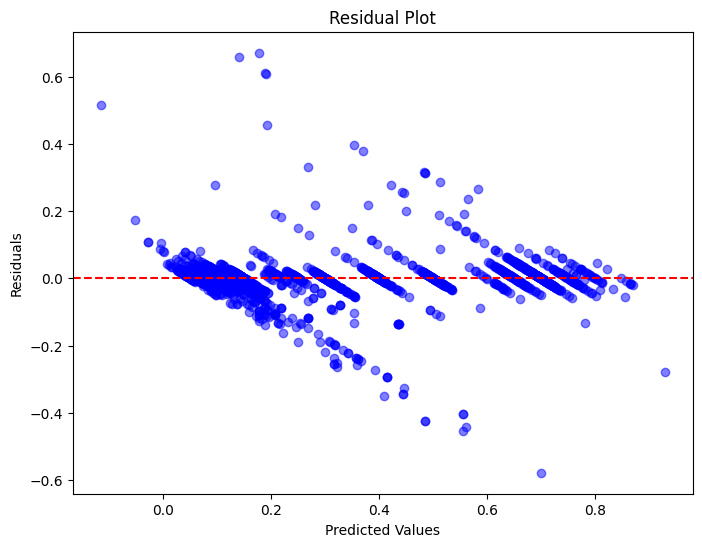

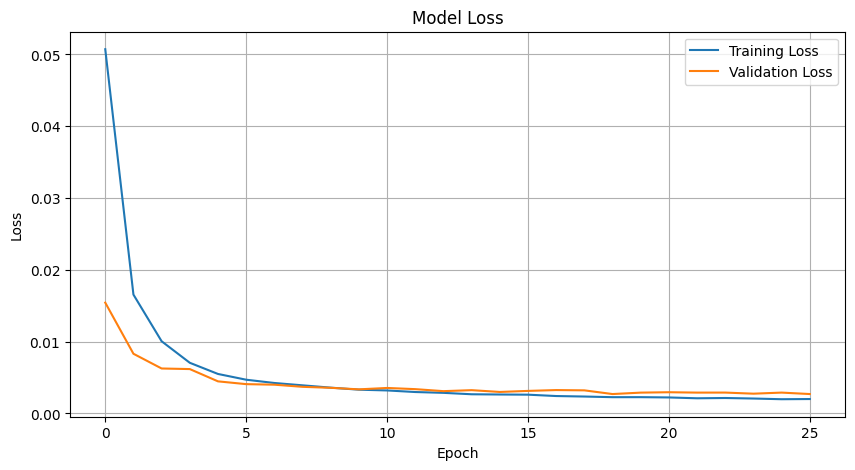

Top 10 Examples with the Furthest Score Differences:
Example 1:
Actual Sentiment Score: 0.85
Predicted Sentiment Score: 0.178
Difference: 0.672
Sentence: avengers endgame

Example 2:
Actual Sentiment Score: 0.8
Predicted Sentiment Score: 0.140
Difference: 0.660
Sentence: this moving picture show

Example 3:
Actual Sentiment Score: 0.8
Predicted Sentiment Score: 0.189
Difference: 0.611
Sentence: this film

Example 4:
Actual Sentiment Score: 0.8
Predicted Sentiment Score: 0.190
Difference: 0.610
Sentence: this movie

Example 5:
Actual Sentiment Score: 0.12
Predicted Sentiment Score: 0.699
Difference: 0.579
Sentence: this flick is

Example 6:
Actual Sentiment Score: 0.4
Predicted Sentiment Score: -0.115
Difference: 0.515
Sentence: whelm activity

Example 7:
Actual Sentiment Score: 0.65
Predicted Sentiment Score: 0.193
Difference: 0.457
Sentence: the film

Example 8:
Actual Sentiment Score: 0.1
Predicted Sentiment Score: 0.555
Difference: 0.455
Sentence: this cinema

Example 9:
Actual Sent

In [108]:
# Evaluation
evaluate_regression_results(X_test_augmented, y_test_augmented, history)

## Using Combined Pretrained GloVe and fasttext vectors

Explanation 
- We used a combination of FastText and GloVe embeddings. FastText captures subword information and provides embeddings for out-of-vocabulary words, while GloVe learns word embeddings based on co-occurrence probabilities.
- By combining both, the model can benefit from a more comprehensive representation of words, capturing both morphological and semantic aspects.

Reference: https://www.sciencedirect.com/science/article/pii/S1877050922010134

### Modelling

In [115]:
# Load GloVe vectors into a dictionary
def load_glove_vectors(glove_file_path):
    glove_model = {}
    with open(glove_file_path, 'r', encoding='utf8') as f:
        for line in f:
            split_line = line.split()
            word = split_line[0]
            embedding = np.array([float(val) for val in split_line[1:]])
            glove_model[word] = embedding
    return glove_model

# Load FastText vectors using gensim
def load_fasttext_vectors(fasttext_file_path):
    return KeyedVectors.load_word2vec_format(fasttext_file_path, binary=False)

# Create the embedding matrix
def create_embedding_matrix(vocab, glove_model, fasttext_model, embedding_dim=300):
    embedding_matrix = np.zeros((len(vocab) + 1, 2 * embedding_dim))  # +1 for padding token
    for word, i in vocab.items():
        embedding_vector = get_combined_embedding(word, glove_model, fasttext_model, embedding_dim)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
    return embedding_matrix

# Function to concatenate embeddings
def get_combined_embedding(word, glove_model, fasttext_model, embedding_dim=300):
    if word in glove_model and word in fasttext_model:
        combined_embedding = np.concatenate((glove_model[word], fasttext_model[word]))
    elif word in glove_model:
        combined_embedding = np.concatenate((glove_model[word], np.zeros(embedding_dim)))
    elif word in fasttext_model:
        combined_embedding = np.concatenate((np.zeros(embedding_dim), fasttext_model[word]))
    else:
        combined_embedding = np.zeros(2 * embedding_dim)  # If word is not found in both
    return combined_embedding

# Load the GloVe and FastText models
glove_model = load_glove_vectors('Text_representations/glove.6B.300d.txt')
fasttext_model = load_fasttext_vectors('Text_representations/wiki-news-300d-1M-subword.vec')

# Create the embedding matrix
embedding_matrix = create_embedding_matrix(word_index_augmented, glove_model, fasttext_model, embedding_dim=300)

# Create model
model = Sequential()
model.add(Embedding(input_dim=total_words_augmented, 
                    output_dim=2 * 300, 
                    weights=[embedding_matrix], 
                    input_length=max_sequence_len_augmented, 
                    trainable=True))  # Set trainable to False to use the pre-trained embeddings as is
model.add(GRU(256)) 
model.add(Dropout(0.25))
model.add(Dense(1, activation='linear'))

# Compile model
model.compile(loss='mean_squared_error', 
              optimizer='adam')

# View the layer summary
model.summary()

# EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Fit the model with both callbacks
history = model.fit(X_train_augmented, y_train_augmented, 
                    validation_data=(X_test_augmented, y_test_augmented), 
                    epochs=40, batch_size=128, verbose=1, 
                    callbacks=[early_stopping])


Model: "sequential_61"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_61 (Embedding)    (None, 58, 600)           1101600   
                                                                 
 gru_61 (GRU)                (None, 256)               658944    
                                                                 
 dropout_63 (Dropout)        (None, 256)               0         
                                                                 
 dense_62 (Dense)            (None, 1)                 257       
                                                                 
Total params: 1,760,801
Trainable params: 1,760,801
Non-trainable params: 0
_________________________________________________________________
Epoch 1/40
110/110 [==============================] - 3s 12ms/step - loss: 0.0481 - val_loss: 0.0122
Epoch 2/40
110/110 [==============================] - 1s 9ms/step - loss: 

### Classification Evaluation

110/110 [==============================] - 0s 2ms/step
Classification Accuracy: 99.37%



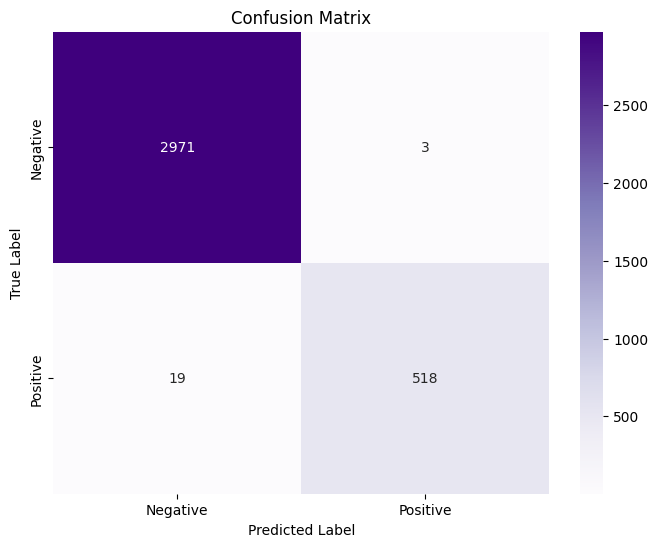


Classification Report:
              precision    recall  f1-score   support

    Negative       0.99      1.00      1.00      2974
    Positive       0.99      0.96      0.98       537

    accuracy                           0.99      3511
   macro avg       0.99      0.98      0.99      3511
weighted avg       0.99      0.99      0.99      3511



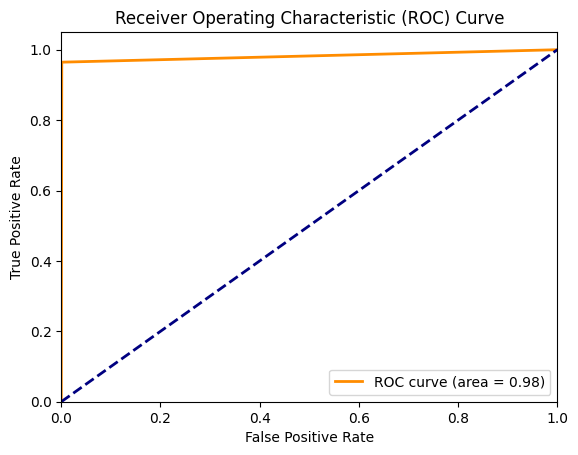


Wrongly Classified Reviews:
True Label: Positive
Predicted Label: Negative
Review: straight story

True Label: Positive
Predicted Label: Negative
Review: improbable playacting

True Label: Positive
Predicted Label: Negative
Review: endgame avengers

True Label: Positive
Predicted Label: Negative
Review: this film

True Label: Positive
Predicted Label: Negative
Review: the film

True Label: Positive
Predicted Label: Negative
Review: underwhelming import

True Label: Positive
Predicted Label: Negative
Review: too many

True Label: Negative
Predicted Label: Positive
Review: despite its

True Label: Positive
Predicted Label: Negative
Review: the loose

True Label: Positive
Predicted Label: Negative
Review: this movie

True Label: Negative
Predicted Label: Positive
Review: this plastic film is

True Label: Positive
Predicted Label: Negative
Review: i m

True Label: Positive
Predicted Label: Negative
Review: an loose

True Label: Positive
Predicted Label: Negative
Review: avenger end

True 

In [116]:
# Evaluation
evaluate_classification_results(X_test_augmented, y_test_augmented) # 98.58

### Regression Evaluation

110/110 [==============================] - 0s 4ms/step
Regression Model Evaluation Results:
R^2 Score: 94.61%
Mean Squared Error (MSE): 0.0027
Mean Absolute Error (MAE): 0.0232


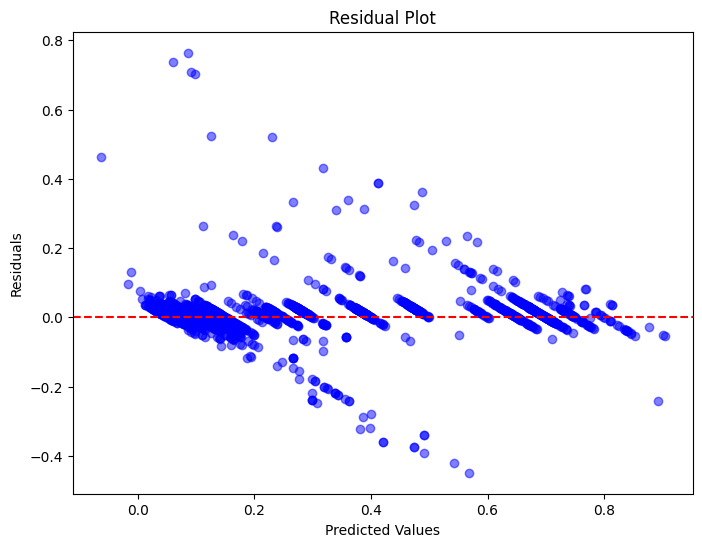

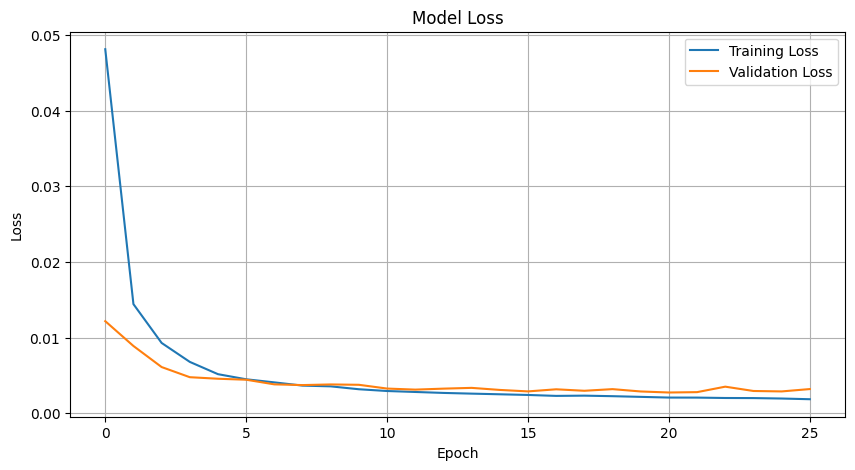

Top 10 Examples with the Furthest Score Differences:
Example 1:
Actual Sentiment Score: 0.85
Predicted Sentiment Score: 0.086
Difference: 0.764
Sentence: avengers endgame

Example 2:
Actual Sentiment Score: 0.8
Predicted Sentiment Score: 0.061
Difference: 0.739
Sentence: this moving picture show

Example 3:
Actual Sentiment Score: 0.8
Predicted Sentiment Score: 0.091
Difference: 0.709
Sentence: this movie

Example 4:
Actual Sentiment Score: 0.8
Predicted Sentiment Score: 0.098
Difference: 0.702
Sentence: this film

Example 5:
Actual Sentiment Score: 0.65
Predicted Sentiment Score: 0.126
Difference: 0.524
Sentence: the film

Example 6:
Actual Sentiment Score: 0.75
Predicted Sentiment Score: 0.230
Difference: 0.520
Sentence: improbable playacting

Example 7:
Actual Sentiment Score: 0.4
Predicted Sentiment Score: -0.063
Difference: 0.463
Sentence: whelm activity

Example 8:
Actual Sentiment Score: 0.12
Predicted Sentiment Score: 0.569
Difference: 0.449
Sentence: this flick is

Example 9:


In [118]:
# Evaluation
evaluate_regression_results(X_test_augmented, y_test_augmented, history)

# **Model Improvement**

## RandomSearchCV + Stratified Kfold

RandomSearchCV Explanation
- RandomSearchCV requires fewer iterations than GridSearchCv as it samples a fixed number of parameter settings, hence its more efficient in the context of Deep Learning neural networks.
- It provides a more diverse exploration of hyperparameter space which is beneficial for finding good hyperparameter configurations.
- RandomizedSearchCV is preferred for efficiency, scalability, and exploration of the hyperparameter space.

Kfold Explanation
- KFold is a cross-validation technique that splits the dataset into k consecutive folds of approximately equal size.
- It improves generalization to unseen data as they are trained on a more diverse set of samples from different folds.
- It can prevent overfitting of the training dataset.

Reference:
1. https://www.linkedin.com/pulse/model-optimization-machine-learning-random-vs-neves-junior-phd-x459f/
2. https://www.shiksha.com/online-courses/articles/k-fold-cross-validation/#What-is-cross-validation?

### Initializing

In [53]:
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import RandomizedSearchCV, KFold

# Define the grid of hyperparameters to search over
param_dist = {
    'units': [128, 256, 512],
    'dropout_rate': [0.25, 0.3],
    'space': [32, 64, 128],
    'epochs': [20, 30],
    'batch_size': [64, 128]
}

# Function to create the base model
def create_model(units=256, dropout_rate=0.25, space=32):
    model = Sequential()
    model.add(Embedding(total_words_augmented, space, input_length=max_sequence_len_augmented))
    model.add(GRU(units)) 
    model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='linear'))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

# Stratified K-Fold cross-validation
kf = KFold(n_splits=3, shuffle=True, random_state=42)

# Create KerasRegressor
model = KerasRegressor(build_fn=create_model, verbose=0)

# Initialize and fit the RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=model, param_distributions=param_dist, 
                                   scoring='neg_mean_absolute_error', cv=kf, verbose=1)
random_result = random_search.fit(X_train_augmented, y_train_augmented)

# Print the best hyperparameters found
print("Best Parameters:", random_result.best_params_)
print("Best Score:", random_result.best_score_)

# Get the best model from RandomizedSearchCV
model = random_result.best_estimator_

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best Parameters: {'units': 512, 'space': 64, 'epochs': 20, 'dropout_rate': 0.25, 'batch_size': 64}
Best Score: -0.02235816194158771


### Best params model (Classification)

Classification Accuracy: 96.10%



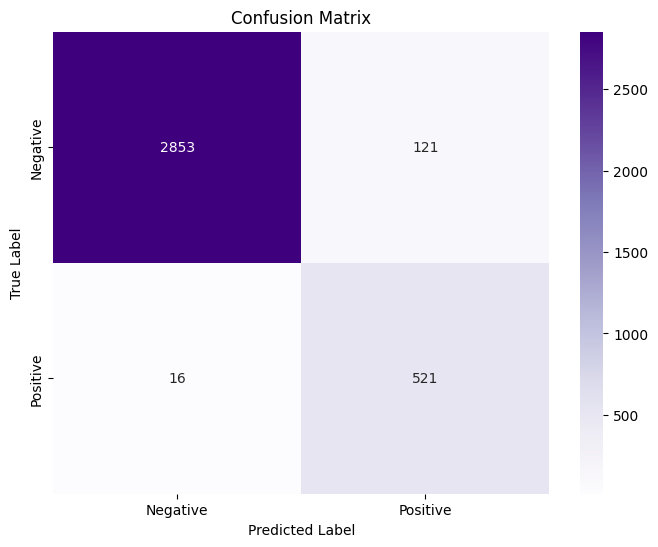


Classification Report:
              precision    recall  f1-score   support

    Negative       0.99      0.96      0.98      2974
    Positive       0.81      0.97      0.88       537

    accuracy                           0.96      3511
   macro avg       0.90      0.96      0.93      3511
weighted avg       0.97      0.96      0.96      3511



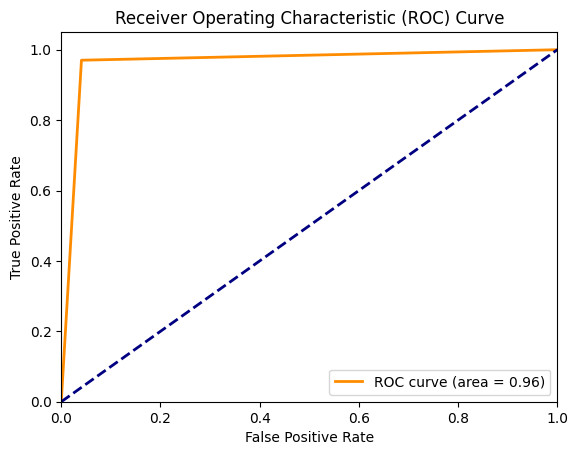


Wrongly Classified Reviews:
True Label: Positive
Predicted Label: Negative
Review: straight story

True Label: Negative
Predicted Label: Positive
Review: despite its ambitious narrative avenger endgame stumbles with pacing issues will some moments smell rushed

True Label: Negative
Predicted Label: Positive
Review: while avengers endgame has its instant of brilliance the balance between thrilling action and a cohesive plot of ground feels somewhat skewed some action vista whitethorn overshadow the narrative impacting the

True Label: Negative
Predicted Label: Positive
Review: while avengers endgame has its instant of brilliance the balance between thrilling action and a cohesive plot of ground feels somewhat skewed some action vista whitethorn overshadow the narrative impacting the overall tempo a more harmonious blend would have elevated the film even

True Label: Negative
Predicted Label: Positive
Review: while avengers end game has its moments of brilliance it stumbles in maintaini

In [54]:
# Evaluation
evaluate_classification_results(X_test_augmented, y_test_augmented)

### Best params model (Regression)

Regression Model Evaluation Results:
R^2 Score: 94.09%
Mean Squared Error (MSE): 0.0030
Mean Absolute Error (MAE): 0.0210


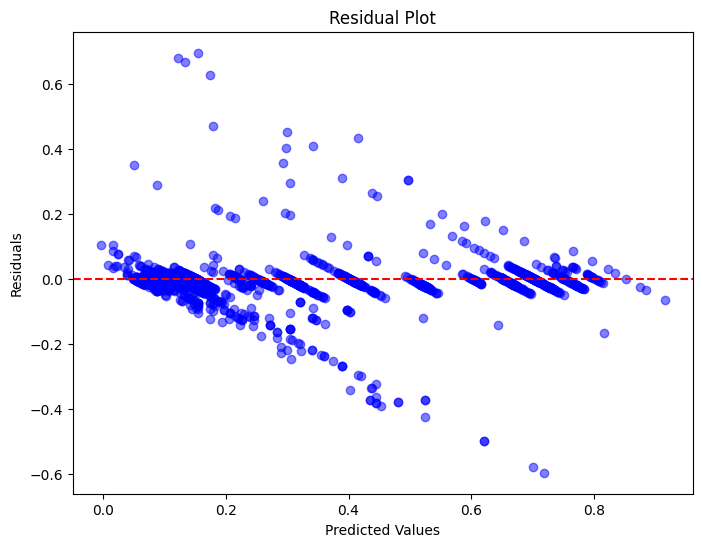

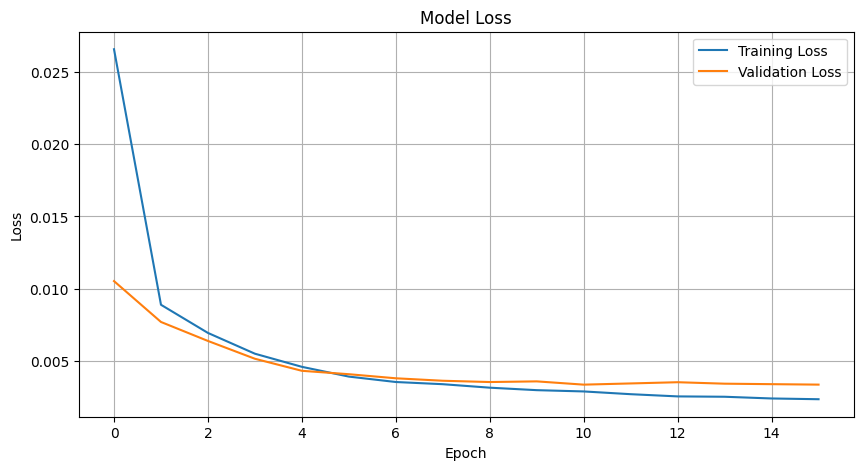

Top 10 Examples with the Furthest Score Differences:
Example 1:
Actual Sentiment Score: 0.85
Predicted Sentiment Score: 0.155
Difference: 0.695
Sentence: avengers endgame

Example 2:
Actual Sentiment Score: 0.8
Predicted Sentiment Score: 0.123
Difference: 0.677
Sentence: this moving picture show

Example 3:
Actual Sentiment Score: 0.8
Predicted Sentiment Score: 0.133
Difference: 0.667
Sentence: this movie

Example 4:
Actual Sentiment Score: 0.8
Predicted Sentiment Score: 0.175
Difference: 0.625
Sentence: this film

Example 5:
Actual Sentiment Score: 0.12
Predicted Sentiment Score: 0.717
Difference: 0.597
Sentence: this flick is

Example 6:
Actual Sentiment Score: 0.12
Predicted Sentiment Score: 0.700
Difference: 0.580
Sentence: this plastic film is

Example 7:
Actual Sentiment Score: 0.12
Predicted Sentiment Score: 0.621
Difference: 0.501
Sentence: this picture

Example 8:
Actual Sentiment Score: 0.12
Predicted Sentiment Score: 0.621
Difference: 0.501
Sentence: this picture

Example 9:

In [55]:
# Evaluation
evaluate_regression_results(X_test_augmented, y_test_augmented, history)

## Finding the best optimizer

Optimizer
- Adam (Adaptive Moment Estimation) adapts the learning rate during training and keeps an exponentially decaying average of past gradients.
- RMSprop (Root Mean Square Propagation) divides the learning rate by the root of this moving average, which helps to normalize the updates and improve convergence.
- SGD (Stochastic Gradient Descent) updates the parameters of the model in the direction of the negative gradient of the loss function with respect to the parameters.
- Adagrad (Adaptive Gradient Descent) uses different learning rates for each iteration. The more the parameters get changed, the more minor the learning rate changes.

References: https://www.analyticsvidhya.com/blog/2021/10/a-comprehensive-guide-on-deep-learning-optimizers/

### Initializing

In [56]:
# list of optimizers to test
optimizers = ['adam', 'rmsprop', 'sgd', 'Adagrad']

# Store the results
results = {}

for optimizer_name in optimizers:
    # Create model
    model = Sequential()
    model.add(Embedding(total_words_augmented, 32, input_length=max_sequence_len_augmented))
    model.add(GRU(256, return_sequences=True))
    model.add(Dropout(0.25))
    model.add(GRU(256))
    model.add(Dropout(0.25))
    model.add(Dense(1, activation='linear'))
    
    # Compile model
    model.compile(loss='mean_squared_error',
                  optimizer=optimizer_name)  

    # EarlyStopping
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    
    # Fit the model
    history = model.fit(X_train_augmented, y_train_augmented, validation_data=(X_test_augmented, y_test_augmented), 
                        epochs=40, batch_size=128, verbose=1, callbacks=[early_stopping])

    # Evaluate the model
    y_pred = model.predict(X_test_augmented)
    
    r2 = r2_score(y_test_augmented, y_pred)
    mse = mean_squared_error(y_test_augmented, y_pred)
    mae = mean_absolute_error(y_test_augmented, y_pred)
    
    # Store the results
    results[optimizer_name] = {'R2': r2, 'MSE': mse, 'MAE': mae}

# Sort the results dictionary based on R2 score
sorted_results = sorted(results.items(), key=lambda x: x[1]['R2'], reverse=True)

Epoch 1/40
110/110 [==============================] - 4s 17ms/step - loss: 0.0241 - val_loss: 0.0096
Epoch 2/40
110/110 [==============================] - 1s 12ms/step - loss: 0.0089 - val_loss: 0.0078
Epoch 3/40
110/110 [==============================] - 1s 12ms/step - loss: 0.0072 - val_loss: 0.0065
Epoch 4/40
110/110 [==============================] - 1s 12ms/step - loss: 0.0060 - val_loss: 0.0056
Epoch 5/40
110/110 [==============================] - 1s 12ms/step - loss: 0.0051 - val_loss: 0.0048
Epoch 6/40
110/110 [==============================] - 1s 12ms/step - loss: 0.0043 - val_loss: 0.0041
Epoch 7/40
110/110 [==============================] - 1s 12ms/step - loss: 0.0039 - val_loss: 0.0043
Epoch 8/40
110/110 [==============================] - 1s 12ms/step - loss: 0.0034 - val_loss: 0.0036
Epoch 9/40
110/110 [==============================] - 1s 12ms/step - loss: 0.0031 - val_loss: 0.0038
Epoch 10/40
110/110 [==============================] - 2s 15ms/step - loss: 0.0030 - val_lo

### Best Optimizers

In [57]:
# Print the optimizer with the best R2 score
best_optimizer = sorted_results[0][0]
best_r2_score = sorted_results[0][1]['R2']

print("Best Optimizer (based on R2 score):", best_optimizer)
print(f"Best R2 Score: {best_r2_score*100:.2f}%")

Best Optimizer (based on R2 score): adam
Best R2 Score: 94.21%


# **Best Model**

## Modelling

In [311]:
# Create model
model = Sequential()
model.add(Embedding(total_words_augmented, 64, input_length=max_sequence_len_augmented))
model.add(GRU(512)) 
model.add(Dropout(0.25))
model.add(Dense(1, activation='linear'))

# Compile model
model.compile(loss='mean_squared_error',
              optimizer='adam')  

# View the layer summary
model.summary()

# EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5)

# ModelCheckpoint
model_checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)

# Fit the model
history = model.fit(X_train_augmented, y_train_augmented, 
                    validation_data=(X_test_augmented, y_test_augmented), 
                    epochs=40, batch_size=64, verbose=1, callbacks=[early_stopping, model_checkpoint])

Model: "sequential_85"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_85 (Embedding)    (None, 59, 64)            113984    
                                                                 
 gru_85 (GRU)                (None, 512)               887808    
                                                                 
 dropout_82 (Dropout)        (None, 512)               0         
                                                                 
 dense_82 (Dense)            (None, 1)                 513       
                                                                 
Total params: 1,002,305
Trainable params: 1,002,305
Non-trainable params: 0
_________________________________________________________________
Epoch 1/40
206/206 [==============================] - 4s 13ms/step - loss: 0.0195 - val_loss: 0.0084
Epoch 2/40
206/206 [==============================] - 2s 11ms/step - loss:

## Classification Evaluation

103/103 [==============================] - 0s 3ms/step
Classification Accuracy: 99.03%



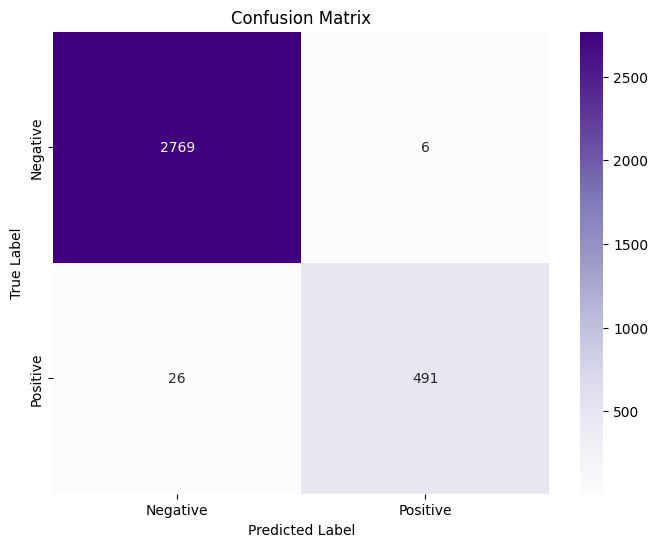


Classification Report:
              precision    recall  f1-score   support

    Negative       0.99      1.00      0.99      2775
    Positive       0.99      0.95      0.97       517

    accuracy                           0.99      3292
   macro avg       0.99      0.97      0.98      3292
weighted avg       0.99      0.99      0.99      3292



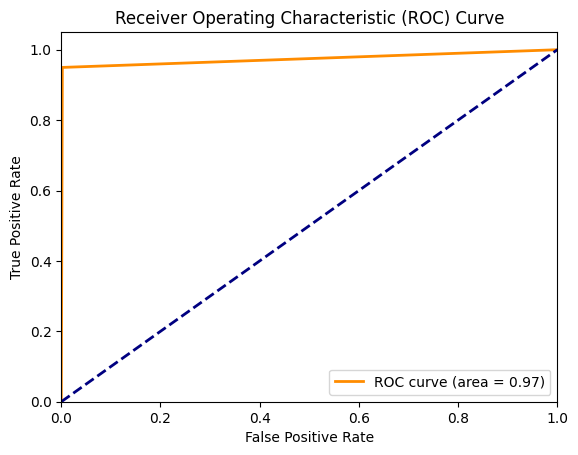


Wrongly Classified Reviews:
True Label: Positive
Predicted Label: Negative
Review: the twist

True Label: Negative
Predicted Label: Positive
Review: this plastic film is

True Label: Positive
Predicted Label: Negative
Review: this film

True Label: Positive
Predicted Label: Negative
Review: the twist in the plot

True Label: Negative
Predicted Label: Positive
Review: the action mechanism is thrilling but the plot of land palpate somewhat fallible the balance is not

True Label: Positive
Predicted Label: Negative
Review: the picture show

True Label: Positive
Predicted Label: Negative
Review: the film

True Label: Positive
Predicted Label: Negative
Review: too many

True Label: Negative
Predicted Label: Positive
Review: the action is thrilling

True Label: Positive
Predicted Label: Negative
Review: the actors

True Label: Positive
Predicted Label: Negative
Review: faint portrayal

True Label: Positive
Predicted Label: Negative
Review: the actors

True Label: Positive
Predicted Label: N

In [312]:
# Evaluation
evaluate_classification_results(X_test_augmented, y_test_augmented)

## Regression Evaluation

103/103 [==============================] - 0s 3ms/step
Regression Model Evaluation Results:
R^2 Score: 94.71%
Mean Squared Error (MSE): 0.0027
Mean Absolute Error (MAE): 0.0204


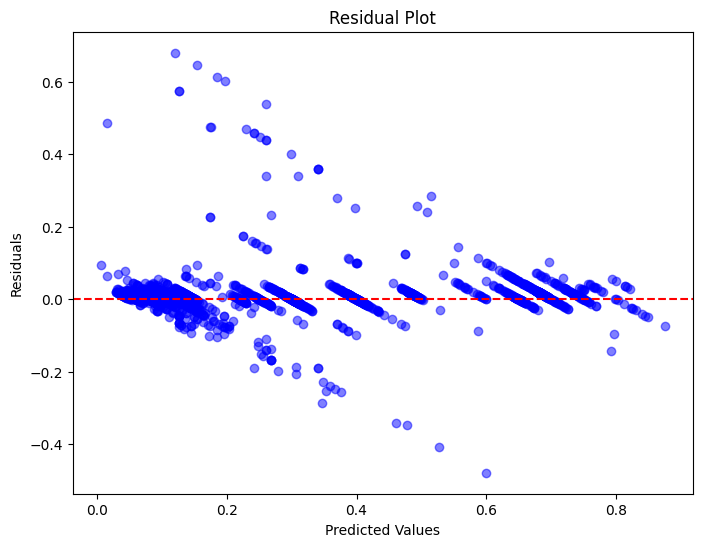

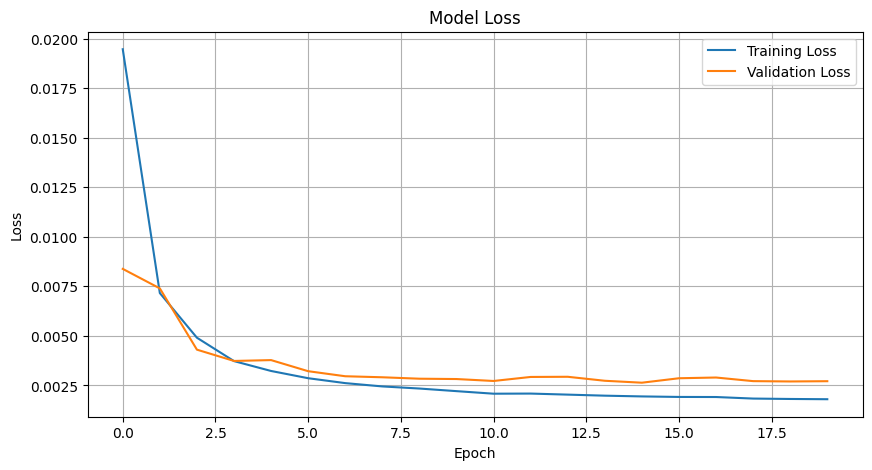

Top 10 Examples with the Furthest Score Differences:
Example 1:
Actual Sentiment Score: 0.8
Predicted Sentiment Score: 0.119
Difference: 0.681
Sentence: this picture show

Example 2:
Actual Sentiment Score: 0.8
Predicted Sentiment Score: 0.155
Difference: 0.645
Sentence: this film

Example 3:
Actual Sentiment Score: 0.8
Predicted Sentiment Score: 0.185
Difference: 0.615
Sentence: this picture show is

Example 4:
Actual Sentiment Score: 0.8
Predicted Sentiment Score: 0.197
Difference: 0.603
Sentence: this photographic film

Example 5:
Actual Sentiment Score: 0.7
Predicted Sentiment Score: 0.126
Difference: 0.574
Sentence: avengers endgame

Example 6:
Actual Sentiment Score: 0.7
Predicted Sentiment Score: 0.126
Difference: 0.574
Sentence: avengers endgame

Example 7:
Actual Sentiment Score: 0.8
Predicted Sentiment Score: 0.260
Difference: 0.540
Sentence: i m

Example 8:
Actual Sentiment Score: 0.5
Predicted Sentiment Score: 0.015
Difference: 0.485
Sentence: vibrate natural

Example 9:
Ac

In [313]:
# Evaluation
evaluate_regression_results(X_test_augmented, y_test_augmented, history)

# **Load Best Model**

103/103 [==============================] - 0s 3ms/step
Classification Accuracy: 99.00%



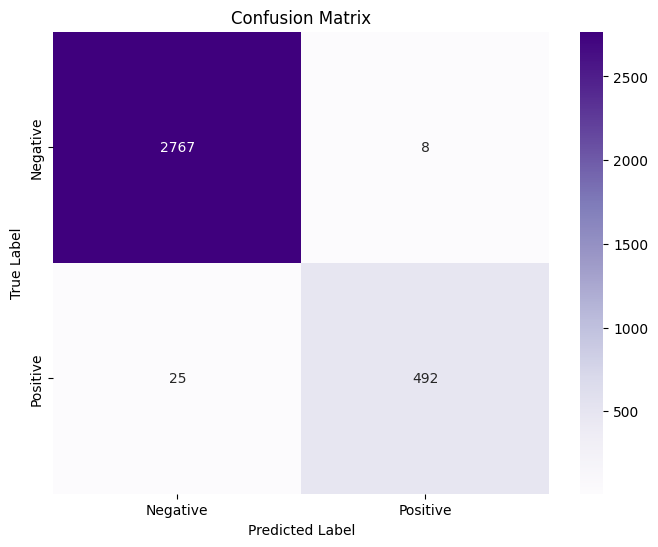


Classification Report:
              precision    recall  f1-score   support

    Negative       0.99      1.00      0.99      2775
    Positive       0.98      0.95      0.97       517

    accuracy                           0.99      3292
   macro avg       0.99      0.97      0.98      3292
weighted avg       0.99      0.99      0.99      3292



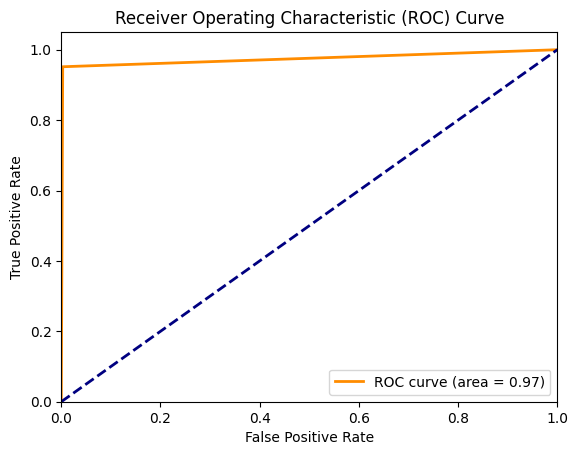


Wrongly Classified Reviews:
True Label: Positive
Predicted Label: Negative
Review: the twist

True Label: Positive
Predicted Label: Negative
Review: this film

True Label: Positive
Predicted Label: Negative
Review: the twist in the plot

True Label: Positive
Predicted Label: Negative
Review: the picture show

True Label: Positive
Predicted Label: Negative
Review: the film

True Label: Negative
Predicted Label: Positive
Review: while avengers endgame has its moments of brilliance it stumbles in maintaining a consistent narrative flow some plot points feel rushed leaving certain character

True Label: Negative
Predicted Label: Positive
Review: while avengers endgame has its moments of brilliance it stagger in maintaining a reproducible narrative flow some plot points feel

True Label: Positive
Predicted Label: Negative
Review: the actors

True Label: Positive
Predicted Label: Negative
Review: the actors

True Label: Positive
Predicted Label: Negative
Review: this film is extremely

True

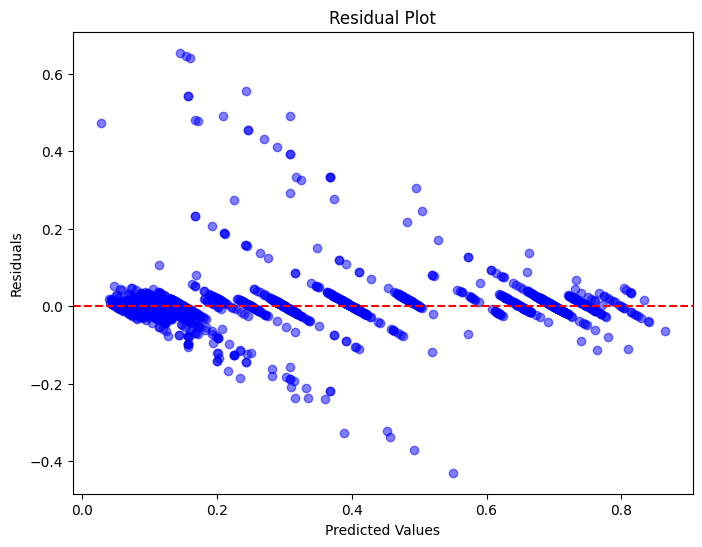

Top 10 Examples with the Furthest Score Differences:
Example 1:
Actual Sentiment Score: 0.8
Predicted Sentiment Score: 0.146
Difference: 0.654
Sentence: this photographic film

Example 2:
Actual Sentiment Score: 0.8
Predicted Sentiment Score: 0.153
Difference: 0.647
Sentence: this picture show

Example 3:
Actual Sentiment Score: 0.8
Predicted Sentiment Score: 0.160
Difference: 0.640
Sentence: this film

Example 4:
Actual Sentiment Score: 0.8
Predicted Sentiment Score: 0.243
Difference: 0.557
Sentence: this picture show is

Example 5:
Actual Sentiment Score: 0.7
Predicted Sentiment Score: 0.156
Difference: 0.544
Sentence: avengers endgame

Example 6:
Actual Sentiment Score: 0.7
Predicted Sentiment Score: 0.156
Difference: 0.544
Sentence: avengers endgame

Example 7:
Actual Sentiment Score: 0.8
Predicted Sentiment Score: 0.308
Difference: 0.492
Sentence: i m

Example 8:
Actual Sentiment Score: 0.7
Predicted Sentiment Score: 0.209
Difference: 0.491
Sentence: the twist in

Example 9:
Actua

In [363]:
from keras.models import load_model

# Load the saved model
model = load_model('99% Accuracy.h5')

# Compile model
model.compile(loss='mean_squared_error',
              optimizer='adam')  

# Evaluation
evaluate_classification_results(X_test_augmented, y_test_augmented)
# Evaluation
evaluate_regression_results(X_test_augmented, y_test_augmented)

# **Extra research and testing** (Tried but wasnt good enough)

## ReduceLROnPlateau callback

- Reduce learning rate when a metric has stopped improving.
- Models often benefit from reducing the learning rate by a factor of 2-10 once learning stagnates.This callback monitors a quantity and if no improvement is seen for a 'patience' number of epochs, the learning rate is reduced.

In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

# ReduceLROnPlateau callback
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)

## Ensemble learning also known as Stacked Generalization (or Stacking)

- In ensemble learning, multiple models are trained and their predictions are combined to make final predictions. Stacking takes this concept further by introducing a meta-model that learns to combine the predictions of multiple base models.
- By combining predictions from multiple models and training a meta-model to learn how to best combine them, stacking often leads to improved performance compared to individual models. Therefore, yes, this code implements a model ensemble using the stacking technique.

In [ ]:
# Define your create_model function
def create_model():
    model = Sequential()
    model.add(Embedding(total_words_augmented, 64, input_length=max_sequence_len_augmented))
    model.add(GRU(512))
    model.add(Dropout(0.25))
    model.add(Dense(1, activation='linear'))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

# Number of base models to train
n_estimators = 5

def create_base_models():
    models = []
    for _ in range(n_estimators):
        model = create_model()
        models.append(model)
    return models

# EarlyStopping and ModelCheckpoint callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train base models
base_models = create_base_models()
X_meta_train = np.zeros((X_train_augmented.shape[0], n_estimators))
X_meta_test = np.zeros((X_test_augmented.shape[0], n_estimators))

for i, model in enumerate(base_models):
    model.fit(X_train_augmented, y_train_augmented, validation_data=(X_test_augmented, y_test_augmented),
              epochs=40, batch_size=64, verbose=1, callbacks=[early_stopping, model_checkpoint])
    X_meta_train[:, i] = model.predict(X_train_augmented).flatten()
    X_meta_test[:, i] = model.predict(X_test_augmented).flatten()

# Train meta-model
meta_model = Sequential()
meta_model.add(Dense(64, activation='relu', input_shape=(n_estimators,)))
meta_model.add(Dense(1, activation='linear'))
meta_model.compile(loss='mean_squared_error', optimizer='adam')

meta_model.fit(X_meta_train, y_train_augmented, validation_data=(X_meta_test, y_test_augmented),
               epochs=40, batch_size=64, verbose=1, callbacks=[early_stopping])

# Make predictions with meta-model
y_pred = meta_model.predict(X_meta_test)

## Word Prediction

- Word prediction is essentially a probabilistic modeling problem, where the goal is to estimate the probability distribution over the vocabulary space to determine the most likely next word.
- It involves training a model to learn the underlying patterns and structures in sequential data, enabling it to generate coherent and contextually relevant predictions for the next word in a sequence.

### Splitting

In [364]:
import numpy as np
from tensorflow.keras.utils import to_categorical

# Extract sequences without scores from padded_input_sequences_augmented
sequences = [item[0] for item in padded_input_sequences_augmented]

# Prepare X by taking all but the last element from each sequence
X = np.array([sequence[:-1] for sequence in sequences])

# Prepare y by taking only the last element from each sequence
y = np.array([sequence[-1] for sequence in sequences])

# Convert y output to One-Hot Encoding
y = to_categorical(y, num_classes=total_words_augmented)

# Info
print(total_words_augmented)
print(X.shape)
print(y.shape)


1781
(16459, 58)
(16459, 1781)


### Evaluation Functions

- Temperature is used to adjust the distribution of predicted probabilities when sampling the next word. It controls the amount of randomness and diverity in the generated text. Higher temperature means that the predicted probabilities become more spread out hence leading to more diverse and creative outputs. Lower temperature means that the redicted probabilities will emphasize on the most probable words and suppress the less probable ones.
- Perplexity measures the quality of language models and quantifies how well a probability distribution predicts a sample of text. Lower Perplextiy indicates that the model is more confident about its predictions and Higher Perplexity indicates that themodel is less certain about its predictions.
- ROUGE is a set of metrics used to evaluate the quality of summaries or machine-generated texts by comparing them to reference texts. ROUGE-1: Measures the overlap of unigrams (single words) between the generated text and the reference text. ROUGE-2: Measures the overlap of bigrams (sequences of two words) between the generated text and the reference text. ROUGE-L: Measures the longest common subsequence (LCS) between the generated text and the reference text.
- WER is a metric used to evaluate the accuracy of automatic speech recognition (ASR) systems or machine translation systems by measuring the difference between the words in the generated output and the reference (ground truth) text.

In [365]:
# Random seeds
seed_texts = [
    "The plot of this movie is",
    "I really enjoyed the",
    "The special effects in this film are",
    "Overall, I thought the acting was",
    "This film has a lot of",
    "The soundtrack of this movie is",
    "One thing I didn't like about the movie was",
    "I was surprised by the",
    "The characters in this film are",
    "I found the ending of the movie"
]


# Function to predict the next word using the model
def generate_text(seed, reps, model, tokenizer, max_sequence_len, temperature=1.0):
    perplex_list = []
    generated_text = seed
    for i in range(reps):
        sequences = tokenizer.texts_to_sequences([seed])
        padded_sequence = pad_sequences(sequences, maxlen=max_sequence_len - 1, padding='pre')
        predict_probs = model.predict(padded_sequence, verbose=0)[0]

        # Temperature-based sampling
        probabilities = np.log(predict_probs) / temperature
        probabilities = np.exp(probabilities) / np.sum(np.exp(probabilities))
        predicted_index = np.random.choice(len(probabilities), p=probabilities)

        output_word = tokenizer.index_word.get(predicted_index, '')
        generated_text += " " + output_word

        # Append the probability of the predicted words
        word_prob = predict_probs[predicted_index]
        perplex_list.append(word_prob)

    # Calculate perplexity
    for i in range(len(perplex_list)):
        perplex_list[i] = 1 / perplex_list[i]  # Convert probabilities to their inverses

    invProbs = np.prod(perplex_list)  # Calculate the product of the inverted probabilities
    perplexity = invProbs ** (1 / reps)  # Calculate the nth root of the product to obtain perplexity

    return generated_text, perplexity


# Function to evaluate the model
def evaluate_model(model, tokenizer, test_data, max_sequence_len, total_words):
    total_rouge_score = {'rouge-1': {'f': 0, 'p': 0, 'r': 0},
                         'rouge-2': {'f': 0, 'p': 0, 'r': 0},
                         'rouge-l': {'f': 0, 'p': 0, 'r': 0}}
    # Variables
    total_loss = 0
    total_wer = 0
    total_perplexity = 0
    total_bleu_score = 0
    num_samples = len(test_data)
    rouge = Rouge()

    for sample in test_data:
        # Convert text data to sequence of int
        sequence = tokenizer.texts_to_sequences([sample['input']])
        sequence = pad_sequences(sequence, maxlen=max_sequence_len - 1, padding='pre')

        # Generate predicted text from model probabilities
        predicted_probs = model.predict(sequence, verbose=0)[0]
        predicted_index = [np.argmax(predicted_probs, axis=-1)]
        predicted_text = tokenizer.sequences_to_texts([predicted_index])[0]

        # Generate reference data for model
        y_true = tokenizer.texts_to_sequences([sample['reference']])
        y_true = pad_sequences(y_true, maxlen=max_sequence_len - 1, padding='pre')
        y_true = tf.keras.utils.to_categorical(y_true, num_classes=total_words)
        y_true = np.expand_dims(y_true, axis=1)

        # Calculate Perplexity
        _, sample_perplexity = generate_text(sample['input'], 1, model, tokenizer, max_sequence_len)
        total_perplexity += sample_perplexity

        # Calculate BLEU score
        reference = sample['reference'].split()  
        hypothesis = predicted_text.split()  
        bleu_score = sentence_bleu([reference], hypothesis)
        total_bleu_score += bleu_score  

        # Calculate ROUGE
        rouge_score = rouge.get_scores(predicted_text, sample['reference'])[0]
        for key in total_rouge_score:
            for metric in total_rouge_score[key]:
                total_rouge_score[key][metric] += rouge_score[key][metric]
                
        # Calculate Cross-Entropy Loss
        loss_metric = model.evaluate(sequence, y_true, verbose=0)
        total_loss += loss_metric[0]
        
        # Calculate Word Error Rate
        wer = jiwer.wer(sample['reference'], predicted_text)
        total_wer += wer

    # Calculate the results
    avg_perplexity = total_perplexity / num_samples
    avg_rouge_score = {key: {metric: total_rouge_score[key][metric] / num_samples for metric in total_rouge_score[key]} for key in total_rouge_score}
    avg_loss = total_loss / num_samples
    avg_wer = total_wer / num_samples
    avg_bleu_score = total_bleu_score / num_samples

    return avg_rouge_score, avg_loss, avg_wer, avg_perplexity, avg_bleu_score

# Function to get random test reviews from data
def test_model(model, tokenizer, data, max_sequence_len, num_test_samples=100):
    # Select random reviews for testing
    test_reviews = random.sample(data, num_test_samples)
    
    test_data = []
    # Construct test data
    for review in test_reviews:
        # Split review into input and reference texts
        input_text = ' '.join(review.split()[:len(review.split()) // 2])
        reference_text = review
        test_data.append({'input': input_text, 'reference': reference_text})

    return test_data

# Function to call test and evaluate model to get the results
def test_and_evaluate_model(model, tokenizer, data, max_sequence_len, total_words, num_test_samples=100):
    # Test model
    test_data = test_model(model, tokenizer, data, max_sequence_len, num_test_samples)

    # Evaluate model
    avg_rouge_score, avg_loss, avg_wer, perplexity, avg_bleu_score = evaluate_model(model, tokenizer, test_data, max_sequence_len, total_words)

    # Print the results
    for rouge_key, scores in avg_rouge_score.items():
        print(f"{rouge_key.upper()} - F1 Score: {scores['f']:.2f}, Precision: {scores['p']:.2f}, Recall: {scores['r']:.2f}")
    print(f"Average Cross-Entropy Loss: {avg_loss:.2f}")
    print(f"Average Word Error Rate: {avg_wer:.2f}")
    print(f"Perplexity: {perplexity:.2f}")
    # print(f"Average BLEU Score: {avg_bleu_score:.2f}")


# Function to plot the val accuracy and val loss graph
def plot_graphs(history):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()

    plt.tight_layout()
    plt.show()

### Simple LSTM model for Word Prediction

In [366]:
# Create model
model = Sequential()
model.add(Embedding(input_dim=total_words_augmented, output_dim=15, input_length=max_sequence_len_augmented - 1))
model.add(LSTM(512))
model.add(Dropout(0.3))
model.add(Dense(total_words_augmented, activation='softmax'))

#Compile model
model.compile(loss='categorical_crossentropy',
              optimizer='adam', 
              metrics=['accuracy'])  

history = model.fit(X, y, epochs=40, batch_size=128, verbose=1, shuffle=True, validation_split=0.05)

# View the layer summary
model.summary()

Epoch 1/40
123/123 [==============================] - 4s 19ms/step - loss: 6.1684 - accuracy: 0.0751 - val_loss: 6.6522 - val_accuracy: 0.0243
Epoch 2/40
123/123 [==============================] - 2s 15ms/step - loss: 5.8764 - accuracy: 0.0785 - val_loss: 6.6426 - val_accuracy: 0.0243
Epoch 3/40
123/123 [==============================] - 2s 14ms/step - loss: 5.7112 - accuracy: 0.0844 - val_loss: 6.5650 - val_accuracy: 0.0486
Epoch 4/40
123/123 [==============================] - 2s 16ms/step - loss: 5.3651 - accuracy: 0.1267 - val_loss: 6.5254 - val_accuracy: 0.0644
Epoch 5/40
123/123 [==============================] - 2s 15ms/step - loss: 4.8748 - accuracy: 0.1634 - val_loss: 6.5069 - val_accuracy: 0.1081
Epoch 6/40
123/123 [==============================] - 2s 17ms/step - loss: 4.2928 - accuracy: 0.2090 - val_loss: 6.5006 - val_accuracy: 0.1385
Epoch 7/40
123/123 [==============================] - 2s 16ms/step - loss: 3.6979 - accuracy: 0.2732 - val_loss: 6.6613 - val_accuracy: 0.1519

### Evaluation

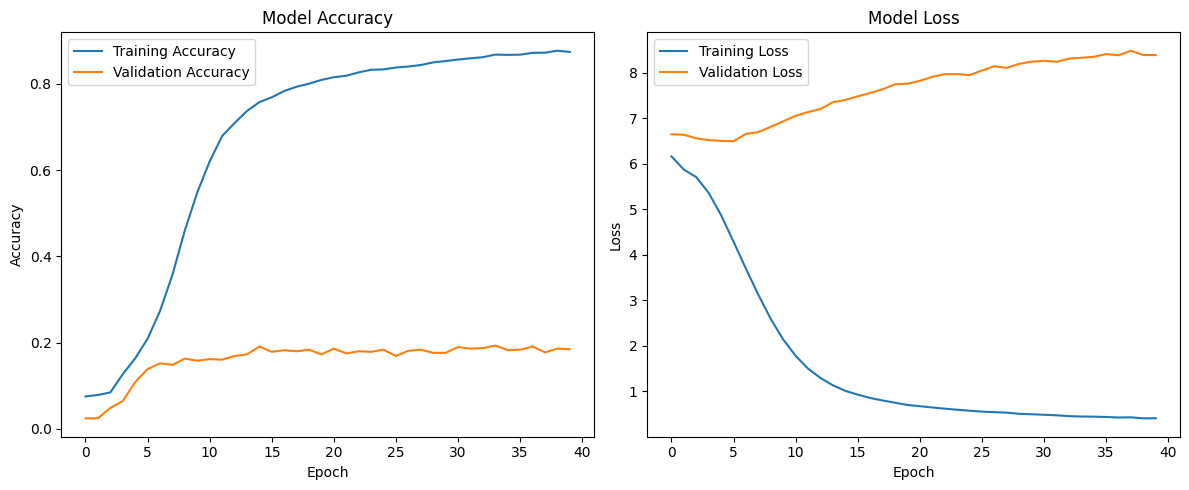

ROUGE-1 - F1 Score: 0.07, Precision: 0.58, Recall: 0.04
ROUGE-2 - F1 Score: 0.00, Precision: 0.00, Recall: 0.00
ROUGE-L - F1 Score: 0.07, Precision: 0.58, Recall: 0.04
Average Cross-Entropy Loss: 14.84
Average Word Error Rate: 0.96
Perplexity: 237.03
Seed: The plot of this movie is
Generated: The plot of this movie is too awe prominent too too interesting with too too refer
Perplexity: 18.648605912038956

Seed: I really enjoyed the
Generated: I really enjoyed the fulfill fulfill movie yarn epic down fulfill and pleased fulfill
Perplexity: 51.87296885773243

Seed: The special effects in this film are
Generated: The special effects in this film are truly truly in truly truly truly truly depth truly truly
Perplexity: 4.239838700195435

Seed: Overall, I thought the acting was
Generated: Overall, I thought the acting was missed complexity expected underwhelmed banquet delight presentation substantial compound plan
Perplexity: 642.6428036299726

Seed: This film has a lot of
Generated: This f

In [367]:
plot_graphs(history)

data2=data['Review'].tolist()

test_and_evaluate_model(model, tokenizer, data2, max_sequence_len_augmented, total_words_augmented)

predicted_texts = []
for seed in seed_texts:
    generated_text, perplexity = generate_text(seed, 10, model, tokenizer, max_sequence_len_augmented, temperature=1.4)
    predicted_texts.append(generated_text)
    print(f"Seed: {seed}")
    print(f"Generated: {generated_text}")
    print(f"Perplexity: {perplexity}\n")
